In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plotting Styling
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams.update({
    "font.family": "serif", "font.serif": "Times New Roman", "mathtext.fontset": "cm",
    'figure.dpi': 100, 'font.size': 16, 'axes.titlesize': 18, 'axes.labelsize': 16,
    'xtick.labelsize': 15, 'ytick.labelsize': 15, 'legend.fontsize': 14
})


Data found at mnist_data.pt
Loaded data shape: torch.Size([6000, 1, 28, 28])


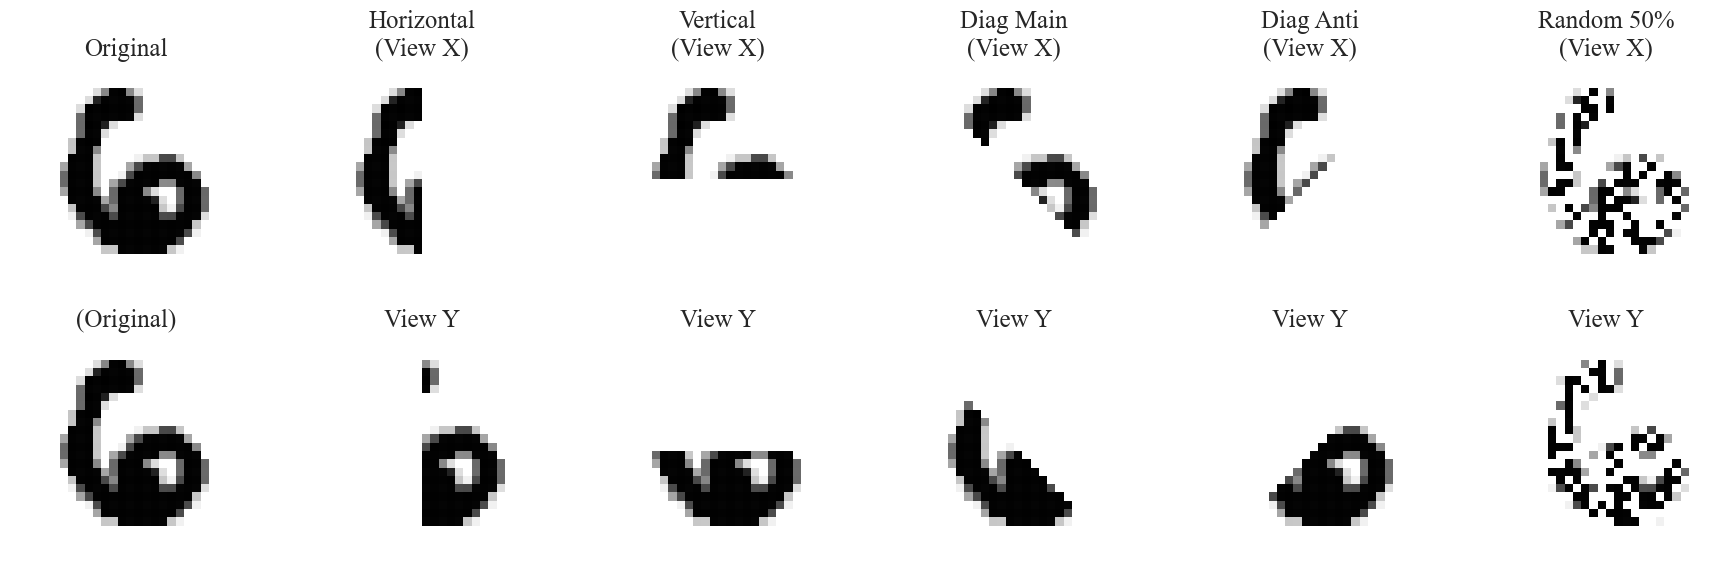

In [21]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# Ensure library is in path
# sys.path.append(os.getcwd())

from dim_est.datasets.special_datasets import SpatialSplitDataset, RandomFeatureDataset

# Configuration
DATA_PATH = "mnist_data.pt"

# 1. Prepare Data (Same as your code)
def prepare_mnist(path, max_samples=6000):
    if os.path.exists(path):
        print(f"Data found at {path}")
        return
        
    print("Downloading MNIST...")
    ds = torchvision.datasets.MNIST(root="./tmp_data", train=True, download=True, 
                                    transform=torchvision.transforms.ToTensor())
    
    # Select subset for speed
    x = ds.data.float() / 255.0  # (60000, 28, 28)
    x = x.unsqueeze(1)           # (60000, 1, 28, 28)
    
    # Take random subset
    indices = torch.randperm(len(x))[:max_samples]
    x_subset = x[indices]
    
    torch.save(x_subset, path)
    print(f"Saved {len(x_subset)} samples to {path}")

# 2. Run Prep
prepare_mnist(DATA_PATH)
full_data = torch.load(DATA_PATH)
print(f"Loaded data shape: {full_data.shape}")

# 3. Define Strategies (Added Random!)
strategies = [
    ("Horizontal", {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 2}}),
    ("Vertical",   {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 1}}),
    ("Diag Main",  {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": 1}}),
    ("Diag Anti",  {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": -1}}),
    ("Random 50%", {"split_strategy": "random_feature", "split_params": {"fraction": 0.5, "seed": 42}}),
]

def visualize_real_dataset_outputs():
    # Pick a specific digit (e.g., index 0)
    sample_img = full_data[0:1] 
    
    # Setup plot: 2 rows (X and Y views), N columns (Original + Strategies)
    n_cols = len(strategies) + 1
    fig, axes = plt.subplots(2, n_cols, figsize=(3 * n_cols, 6))

    # --- Column 0: Original Image ---
    orig_view = sample_img.squeeze()
    
    axes[0, 0].imshow(orig_view, cmap="Greys", vmin=0, vmax=1)
    axes[0, 0].set_title("Original")
    axes[0, 0].axis("off")
    
    axes[1, 0].imshow(orig_view, cmap="Greys", vmin=0, vmax=1)
    axes[1, 0].set_title("(Original)")
    axes[1, 0].axis("off")

    # --- Columns 1-N: Strategies ---
    for i, (name, cfg) in enumerate(strategies):
        col = i + 1
        
        strategy = cfg["split_strategy"]
        params = cfg["split_params"]
        
        # A. Instantiate the Dataset
        # Note: RandomFeatureDataset automatically detects >2D input and enables flattening
        if strategy == "spatial":
            ds = SpatialSplitDataset(sample_img, **params)
        elif strategy == "random_feature":
            ds = RandomFeatureDataset(sample_img, **params)
            
        # B. Get the views (returns tensors)
        x_view, y_view = ds[0]
        
        # C. Reconstruct for Visualization
        img_x = torch.full((28, 28), float('nan'))
        img_y = torch.full((28, 28), float('nan'))
        
        # Case 1: Axis Splits (Geometric Slicing)
        if strategy == "spatial" and params.get("mode", "axis") == "axis":
            h, w = x_view.shape[1], x_view.shape[2]
            
            if params["axis"] == 1: # Vertical split
                img_x[:h, :] = x_view.squeeze()
                img_y[h:, :] = y_view.squeeze()
            else: # Horizontal split
                img_x[:, :w] = x_view.squeeze()
                img_y[:, w:] = y_view.squeeze()

        # Case 2: Index Splits (Diagonal OR Random)
        # This works because both datasets store the indices they used!
        else:
            # RandomFeatureDataset stores .indices_x / .indices_y
            # SpatialSplitDataset(mode='diagonal') ALSO stores .indices_x / .indices_y
            
            # We map the 1D values back to their 2D locations
            # .view(-1) creates a flat view of the 28x28 canvas we can index into
            img_x.view(-1)[ds.indices_x] = x_view
            img_y.view(-1)[ds.indices_y] = y_view
            
        # Plot X (Top Row)
        axes[0, col].imshow(img_x, cmap="Greys", vmin=0, vmax=1)
        axes[0, col].set_title(f"{name}\n(View X)")
        axes[0, col].axis("off")
        
        # Plot Y (Bottom Row)
        axes[1, col].imshow(img_y, cmap="Greys", vmin=0, vmax=1)
        axes[1, col].set_title("View Y")
        axes[1, col].axis("off")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    visualize_real_dataset_outputs()

In [1]:
import torch
import numpy as np
import pandas as pd
import os
import sys

# Ensure library is in path
sys.path.append(os.getcwd())

from dim_est.run.run_single_experiment import run_finite
from dim_est.utils.version_logs import get_git_commit_hash

# --- Configuration ---
DATA_PATH = "mnist_data.pt"
OUTFILE = "temp_finite.h5"
N_SAMPLES = 5000     # Tunable parameter
N_EPOCHS = 100        # Enough to converge
BATCH_SIZE = 256
EMBED_DIM = 128       # High enough to capture ID

# Define the strategies to sweep
strategies = {
    "Horizontal":  {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 2}},
    "Vertical":    {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 1}},
    "Diag_Main":   {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": 1}},
    "Diag_Anti":   {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": -1}},
    "Random_50":   {"split_strategy": "random_feature", "split_params": {"fraction": 0.5, "seed": 42}},
}

def run_estimation_sweep():
    results = []
    
    print(f"--- Starting MNIST ID Estimation (Samples: {N_SAMPLES}) ---")
    
    for name, split_cfg in strategies.items():
        print(f"\n>>> Running Strategy: {name}")
        
        # 1. Setup Overrides
        # Dataset: Point to external file + specific split strategy
        dataset_overrides = {
            "source": "external",
            "data_path": DATA_PATH,
            "split_strategy": split_cfg["split_strategy"],
            "split_params": split_cfg["split_params"],
            # Library automatically handles the 90/10 split internally
        }
        
        # Training: Set epochs, batch size, and sample limit
        training_overrides = {
            "n_epoch": N_EPOCHS,
            "batch_size": BATCH_SIZE,
            "n_samples": N_SAMPLES,
            # We can disable 'eval_train_mode' or set to small number to speed up
            "eval_train_mode": False ,
            "eval_train_mode_final": False,
            "patience": 20,
        }
        
        # Critic: MLP encoder, high dim
        critic_overrides = {
            "encoder_type": "mlp",
            "embed_dim": EMBED_DIM,
            # We let the library infer Nx/Ny from the data shape automatically
        }
        
        # 2. Run Estimation
        try:
            # run_dsib_finite returns: 
            # [mi_train, mi_test], [final_mi_train, final_mi_test], [final_pr_train, final_pr_test], ...
            _, _, final_pr, _, _ = run_finite(
                dataset_type="joint_gaussian", # Label for logging (dataset_overrides dictates actual data)
                critic_type="hybrid",          # Standard critic
                setup="finite_data_epoch",
                outfile=OUTFILE,
                dataset_overrides=dataset_overrides,
                training_overrides=training_overrides,
                critic_overrides=critic_overrides,
                seed=42
            )
            
            # Extract Train PR (D_eff)
            d_eff = final_pr[0] # final_pr is [train_pr, test_pr]
            
            print(f"✅ {name} Completed. D_eff (Train PR): {d_eff:.2f}")
            
            results.append({
                "Strategy": name,
                "Samples": N_SAMPLES,
                "D_eff": d_eff,
            })
            
        except Exception as e:
            print(f"❌ {name} Failed: {e}")
            # Optional: Raise if you want to stop immediately
            # raise e

    # 3. Summary
    print("\n--- Final Results ---")
    df = pd.DataFrame(results)
    print(df)
    
    # Optional: Save detailed CSV
    # df.to_csv("mnist_id_results.csv", index=False)
    return df

if __name__ == "__main__":
    # Ensure data exists (using Phase 1 function if needed, or assuming file exists)
    if not os.path.exists(DATA_PATH):
        print(f"Error: {DATA_PATH} not found. Please run Phase 1 data prep first.")
    else:
        df_out = run_estimation_sweep()

--- Starting MNIST ID Estimation (Samples: 5000) ---

>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [3]:
import torch
import torchvision
import numpy as np
import pandas as pd
import os
import sys

# Ensure library is in path
sys.path.append(os.getcwd())

from dim_est.run.run_dsib_single_experiment import run_dsib_finite


DATA_PATH = "mnist_data.pt"

def prepare_mnist(path, max_samples=6000):
    # if os.path.exists(path):
    #     print(f"Data found at {path}")
    #     return
        
    print("Downloading MNIST...")
    ds = torchvision.datasets.MNIST(root="./tmp_data", train=True, download=True, 
                                    transform=torchvision.transforms.ToTensor())
    
    # Select subset for speed
    x = ds.data.float() / 255.0  # (60000, 28, 28)
    x = x.unsqueeze(1)           # (60000, 1, 28, 28)
    
    # Take random subset
    indices = torch.randperm(len(x))[:max_samples]
    x_subset = x[indices]
    
    torch.save(x_subset, path)
    print(f"Saved {len(x_subset)} samples to {path}")

# --- Configuration ---
DATA_PATH = "mnist_data.pt"
OUTFILE = "temp_finite.h5"
N_EPOCHS = 100        
BATCH_SIZE = 256
EMBED_DIM = 128       


# Define the strategies
strategies = {
    "Horizontal":  {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 2}},
    "Vertical":    {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 1}},
    "Diag_Main":   {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": 1}},
    "Diag_Anti":   {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": -1}},
    "Random_50":   {"split_strategy": "random_feature", "split_params": {"fraction": 0.5, "seed": 42}},
}

# Define sample sizes to sweep: 2^10 to 2^15 (1024 to 32768)
sample_sizes = np.logspace(10, 15, num=6, dtype=int, base=2)


def run_estimation_sweep():
    # Ensure Output Directory Exists
    os.makedirs(os.path.dirname(OUTFILE) if os.path.dirname(OUTFILE) else ".", exist_ok=True)
    
    results = []
    
    print(f"--- Starting MNIST ID Estimation Sweep ---")
    print(f"Sample Sizes: {sample_sizes}")
    
    for n_samples in sample_sizes:
        print(f"\n==========================================")
        print(f"   Testing Sample Size: {n_samples}")
        prepare_mnist(DATA_PATH, max_samples=n_samples)
        print(f"==========================================")
        
        for name, split_cfg in strategies.items():
            print(f">>> Running Strategy: {name}")
            
            # 1. Setup Overrides
            dataset_overrides = {
                "source": "external",
                "data_path": DATA_PATH,
                "split_strategy": split_cfg["split_strategy"],
                "split_params": split_cfg["split_params"],
            }
            
            # Training: update n_samples dynamically
            training_overrides = {
                "n_epoch": N_EPOCHS,
                "batch_size": BATCH_SIZE,
                "n_samples": int(n_samples), # Ensure standard Python int
                "eval_train_mode": BATCH_SIZE,
                "eval_train_mode_final": False,
                "patience": 20,
            }
            
            critic_overrides = {
                "encoder_type": "mlp",
                "embed_dim": EMBED_DIM,
            }
            
            # 2. Run Estimation
            try:
                running_mi, _, final_pr, _, _ = run_dsib_finite(
                    dataset_type="joint_gaussian", 
                    critic_type="hybrid",          
                    setup="finite_data_epoch",
                    outfile=OUTFILE,
                    dataset_overrides=dataset_overrides,
                    training_overrides=training_overrides,
                    critic_overrides=critic_overrides,
                    seed=42
                )
                
                # Extract Train PR (D_eff) and MI information
                d_eff = final_pr[0]
                mi = running_mi[0][np.argmax(running_mi[1])]
                
                print(f"✅ {name} (N={n_samples}) -> D_eff: {d_eff:.2f}, MI: {mi:.2f}")
                
                results.append({
                    "Strategy": name,
                    "Samples": n_samples,
                    "D_eff": d_eff,
                    "MI": mi
                })
                
            except Exception as e:
                print(f"❌ {name} (N={n_samples}) Failed: {e}")
                # Optional: print traceback if needed for deep debugging
                # import traceback
                # traceback.print_exc()

    # 3. Summary
    print("\n--- Final Results ---")
    df = pd.DataFrame(results)
    print(df)
    
    # Save results to CSV for easy plotting later
    # df.to_csv("mnist_sample_sweep_results.csv", index=False)
    return df

In [4]:
df_out = run_estimation_sweep()

--- Starting MNIST ID Estimation Sweep ---
Sample Sizes: [ 1024  2048  4096  8192 16384 32768]

   Testing Sample Size: 1024
Saved 1024 samples to mnist_data.pt
>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 42. Best Smoothed Test MI: 2.7804
Run completed; saved to temp_finite.h5
✅ Horizontal (N=1024) -> D_eff: 1.82, MI: 7.14
>>> Running Strategy: Vertical
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 40. Best Smoothed Test MI: 2.2511
Run completed; saved to temp_finite.h5
✅ Vertical (N=1024) -> D_eff: 1.33, MI: 6.51
>>> Running Strategy: Diag_Main
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 36. Best Smoothed Test MI: 2.3059
Run completed; saved to temp_finite.h5
✅ Diag_Main (N=1024) -> D_eff: 1.31, MI: 6.30
>>> Running Strategy: Diag_Anti
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 43. Best Smoothed Test MI: 2.1555
Run completed; saved to temp_finite.h5
✅ Diag_Anti (N=1024) -> D_eff: 1.44, MI: 6.88
>>> Running Strategy: Random_50
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 45. Best Smoothed Test MI: 3.8704
Run completed; saved to temp_finite.h5
✅ Random_50 (N=1024) -> D_eff: 1.31, MI: 7.90

   Testing Sample Size: 2048
Saved 2048 samples to mnist_data.pt
>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 36. Best Smoothed Test MI: 3.1900
Run completed; saved to temp_finite.h5
✅ Horizontal (N=2048) -> D_eff: 2.30, MI: 6.92
>>> Running Strategy: Vertical
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 40. Best Smoothed Test MI: 3.0572
Run completed; saved to temp_finite.h5
✅ Vertical (N=2048) -> D_eff: 1.79, MI: 6.47
>>> Running Strategy: Diag_Main
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 41. Best Smoothed Test MI: 3.3423
Run completed; saved to temp_finite.h5
✅ Diag_Main (N=2048) -> D_eff: 1.82, MI: 7.73
>>> Running Strategy: Diag_Anti
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 43. Best Smoothed Test MI: 3.1311
Run completed; saved to temp_finite.h5
✅ Diag_Anti (N=2048) -> D_eff: 2.30, MI: 7.46
>>> Running Strategy: Random_50
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Run completed; saved to temp_finite.h5
✅ Random_50 (N=2048) -> D_eff: 1.94, MI: 7.98

   Testing Sample Size: 4096
Saved 4096 samples to mnist_data.pt
>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 42. Best Smoothed Test MI: 3.9693
Run completed; saved to temp_finite.h5
✅ Horizontal (N=4096) -> D_eff: 2.70, MI: 7.66
>>> Running Strategy: Vertical
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 35. Best Smoothed Test MI: 3.7307
Run completed; saved to temp_finite.h5
✅ Vertical (N=4096) -> D_eff: 1.90, MI: 7.02
>>> Running Strategy: Diag_Main
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 43. Best Smoothed Test MI: 4.2786
Run completed; saved to temp_finite.h5
✅ Diag_Main (N=4096) -> D_eff: 2.05, MI: 7.74
>>> Running Strategy: Diag_Anti
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 45. Best Smoothed Test MI: 4.1276
Run completed; saved to temp_finite.h5
✅ Diag_Anti (N=4096) -> D_eff: 2.65, MI: 7.67
>>> Running Strategy: Random_50
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 85. Best Smoothed Test MI: 5.8619
Run completed; saved to temp_finite.h5
✅ Random_50 (N=4096) -> D_eff: 2.93, MI: 7.97

   Testing Sample Size: 8192
Saved 8192 samples to mnist_data.pt
>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 42. Best Smoothed Test MI: 5.0835
Run completed; saved to temp_finite.h5
✅ Horizontal (N=8192) -> D_eff: 2.56, MI: 7.79
>>> Running Strategy: Vertical
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 38. Best Smoothed Test MI: 4.4451
Run completed; saved to temp_finite.h5
✅ Vertical (N=8192) -> D_eff: 1.95, MI: 7.45
>>> Running Strategy: Diag_Main
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 73. Best Smoothed Test MI: 5.3283
Run completed; saved to temp_finite.h5
✅ Diag_Main (N=8192) -> D_eff: 2.79, MI: 7.86
>>> Running Strategy: Diag_Anti
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 51. Best Smoothed Test MI: 5.0161
Run completed; saved to temp_finite.h5
✅ Diag_Anti (N=8192) -> D_eff: 3.32, MI: 7.80
>>> Running Strategy: Random_50
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Run completed; saved to temp_finite.h5
✅ Random_50 (N=8192) -> D_eff: 3.07, MI: 7.97

   Testing Sample Size: 16384
Saved 16384 samples to mnist_data.pt
>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 80. Best Smoothed Test MI: 5.9439
Run completed; saved to temp_finite.h5
✅ Horizontal (N=16384) -> D_eff: 4.29, MI: 7.86
>>> Running Strategy: Vertical
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 60. Best Smoothed Test MI: 5.5082
Run completed; saved to temp_finite.h5
✅ Vertical (N=16384) -> D_eff: 2.66, MI: 7.72
>>> Running Strategy: Diag_Main
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 87. Best Smoothed Test MI: 6.2649
Run completed; saved to temp_finite.h5
✅ Diag_Main (N=16384) -> D_eff: 4.10, MI: 7.85
>>> Running Strategy: Diag_Anti
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 49. Best Smoothed Test MI: 5.8977
Run completed; saved to temp_finite.h5
✅ Diag_Anti (N=16384) -> D_eff: 3.34, MI: 7.73
>>> Running Strategy: Random_50
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 65. Best Smoothed Test MI: 7.2796
Run completed; saved to temp_finite.h5
✅ Random_50 (N=16384) -> D_eff: 3.32, MI: 7.99

   Testing Sample Size: 32768
Saved 32768 samples to mnist_data.pt
>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 84. Best Smoothed Test MI: 6.7501
Run completed; saved to temp_finite.h5
✅ Horizontal (N=32768) -> D_eff: 4.97, MI: 7.83
>>> Running Strategy: Vertical
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 99. Best Smoothed Test MI: 6.2591
Run completed; saved to temp_finite.h5
✅ Vertical (N=32768) -> D_eff: 3.60, MI: 7.74
>>> Running Strategy: Diag_Main
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 58. Best Smoothed Test MI: 6.8415
Run completed; saved to temp_finite.h5
✅ Diag_Main (N=32768) -> D_eff: 3.86, MI: 7.81
>>> Running Strategy: Diag_Anti
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 90. Best Smoothed Test MI: 6.7388
Run completed; saved to temp_finite.h5
✅ Diag_Anti (N=32768) -> D_eff: 4.81, MI: 7.85
>>> Running Strategy: Random_50
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 53. Best Smoothed Test MI: 7.9313
Run completed; saved to temp_finite.h5
✅ Random_50 (N=32768) -> D_eff: 4.39, MI: 7.97

--- Final Results ---
      Strategy  Samples     D_eff        MI
0   Horizontal     1024  1.824992  7.143467
1     Vertical     1024  1.329406  6.509967
2    Diag_Main     1024  1.312620  6.299024
3    Diag_Anti     1024  1.443305  6.881315
4    Random_50     1024  1.310556  7.896639
5   Horizontal     2048  2.300637  6.920958
6     Vertical     2048  1.789315  6.470073
7    Diag_Main     2048  1.821006  7.731634
8    Diag_Anti     2048  2.304694  7.458833
9    Random_50     2048  1.940958  7.976196
10  Horizontal     4096  2.700158  7.664349
11    Vertical     4096  1.896582  7.018662
12   Diag_Main     4096  2.049701  7.742786
13   Diag_Anti     4096  2.648390  7.665272
14   Random_50     4096  2.933460  7.973490
15  Horizontal     8192  2.563354  7.787390
16    Vertical     8192  1.951108  7.454404
17   Diag_Main     8192  2.791526  7.8632

In [13]:
df_out

,Strategy,Samples,D_eff,MI
0,Horizontal,1024,1.824992,7.143467
1,Vertical,1024,1.329406,6.509967
2,Diag_Main,1024,1.312620,6.299024
3,Diag_Anti,1024,1.443305,6.881315
4,Random_50,1024,1.310556,7.896639
5,Horizontal,2048,2.300637,6.920958
6,Vertical,2048,1.789315,6.470073
7,Diag_Main,2048,1.821006,7.731634
8,Diag_Anti,2048,2.304694,7.458833
9,Random_50,2048,1.940958,7.976196


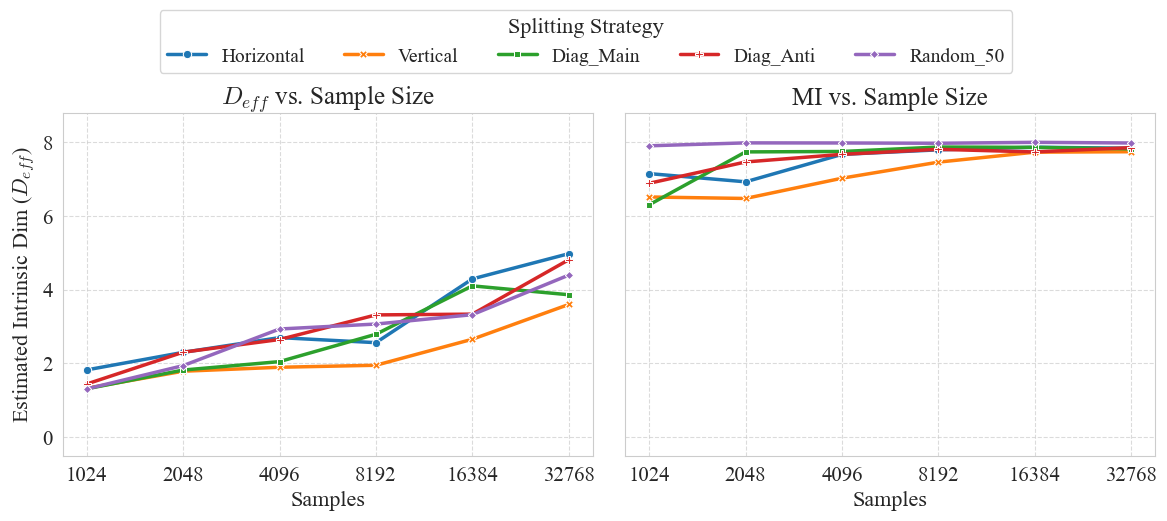

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# 1. Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# 2. Plot D_eff on the first axis
sns.lineplot(
    data=df_out, x="Samples", y="D_eff", hue="Strategy", style="Strategy", 
    markers=True, dashes=False, linewidth=2.5, palette="tab10", ax=ax1,
    legend=False  # Disable internal legend
)
ax1.set_xscale('log', base=2)
ax1.set_ylabel("Estimated Intrinsic Dim ($D_{eff}$)")
ax1.set_title("$D_{eff}$ vs. Sample Size")
ax1.set_ylim(-0.5, 7)

# 3. Plot MI on the second axis
sns.lineplot(
    data=df_out, x="Samples", y="MI", hue="Strategy", style="Strategy", 
    markers=True, dashes=False, linewidth=2.5, palette="tab10", ax=ax2,
    legend=True  # We will extract handles from this one
)
ax2.set_xscale('log', base=2)
ax2.set_ylabel("Mutual Information (MI)")
ax2.set_title("MI vs. Sample Size")
ax2.set_ylim(-0.5, df_out["MI"].max() * 1.1)

# 4. Format X-axes
for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.grid(True, which="both", linestyle='--', alpha=0.7)

# 5. Extract handles and labels for the shared legend
handles, labels = ax2.get_legend_handles_labels()
ax2.get_legend().remove() # Remove the legend from the plot area

# 6. Create the horizontal shared legend above the subplots
fig.legend(
    handles, labels, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.07), # Positioned above the subplots
    ncol=len(labels),           # Horizontal layout
    title="Splitting Strategy"
)

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust figure to fit the legend
plt.show()


In [24]:
np.log2(256)

8.0

--- Starting MNIST ID Estimation (Samples: 5000) ---

>>> Running Strategy: Horizontal
Using device: mps
--- DEBUG MODE ON: Using device mps ---


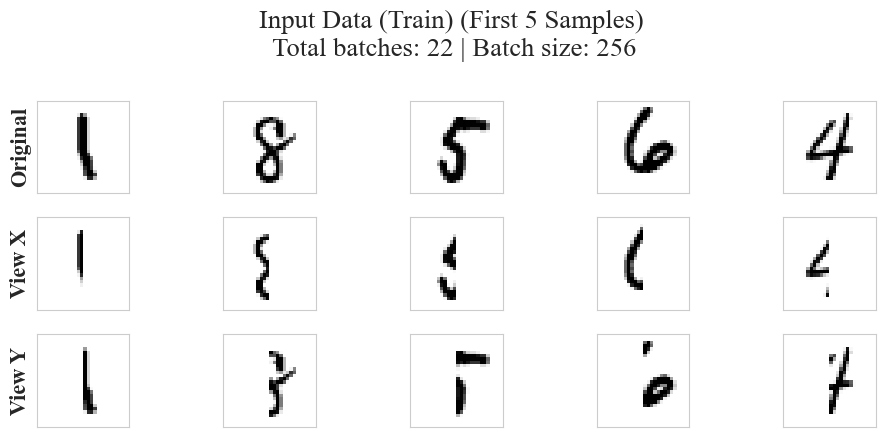

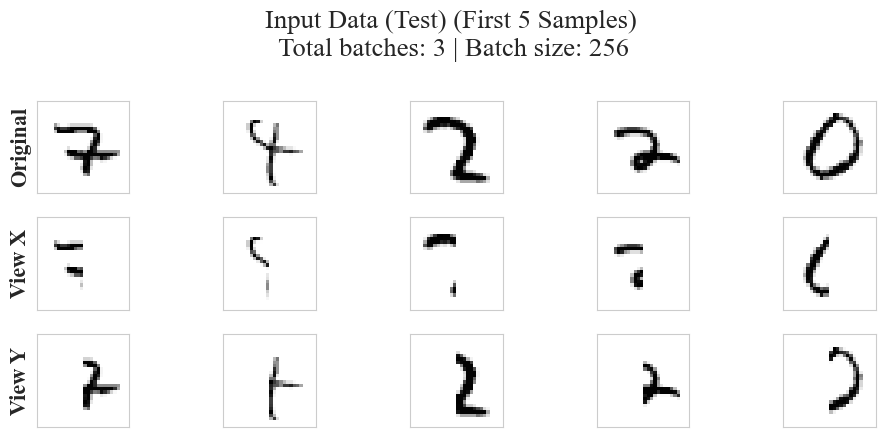

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 53. Best Smoothed Test MI: 4.6924


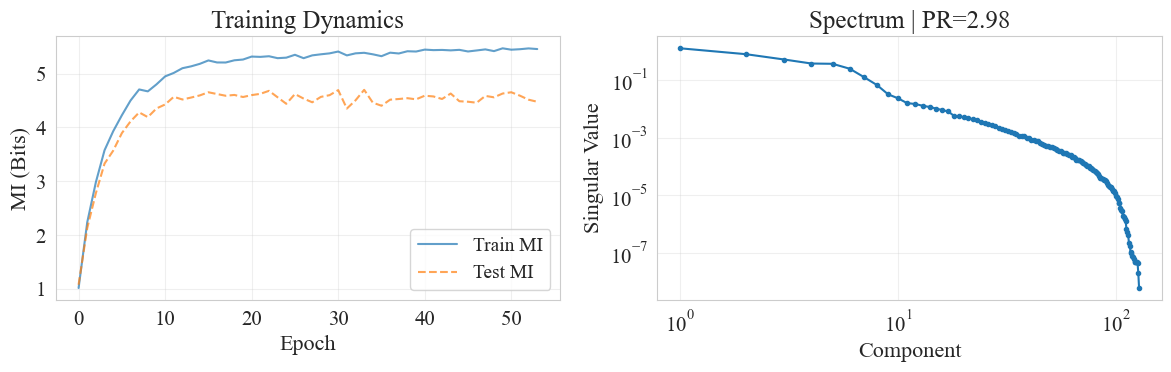

Run completed; saved to temp_finite.h5
✅ Horizontal Completed. D_eff (Train PR): 2.66

>>> Running Strategy: Vertical
Using device: mps
--- DEBUG MODE ON: Using device mps ---


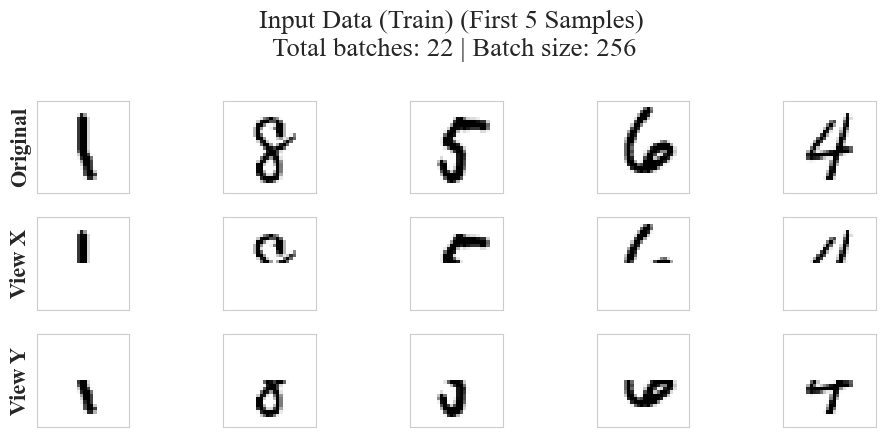

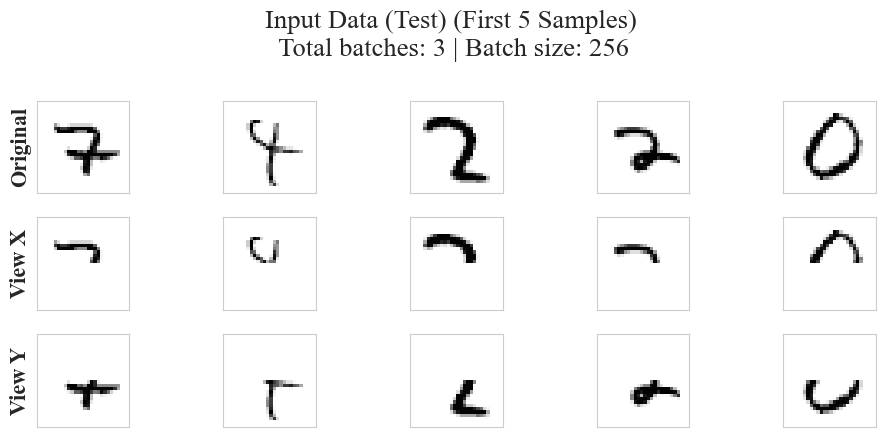

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 40. Best Smoothed Test MI: 3.9703


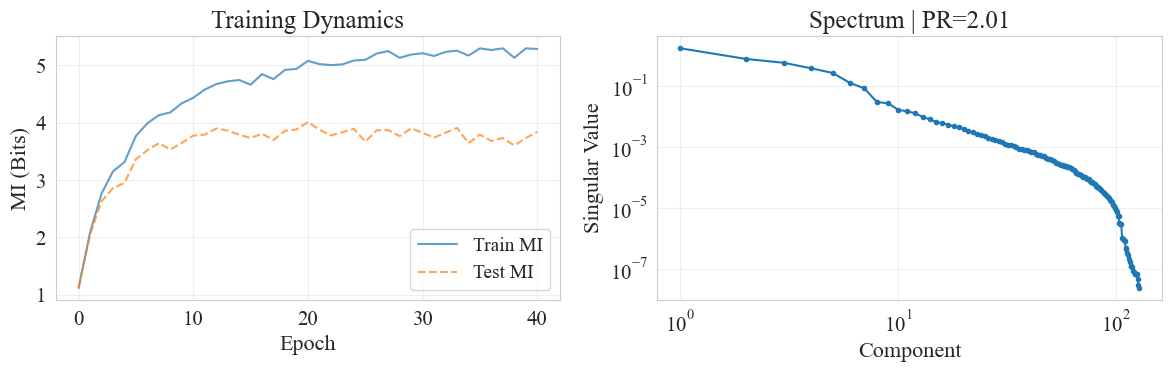

Run completed; saved to temp_finite.h5
✅ Vertical Completed. D_eff (Train PR): 1.84

>>> Running Strategy: Diag_Main
Using device: mps
--- DEBUG MODE ON: Using device mps ---


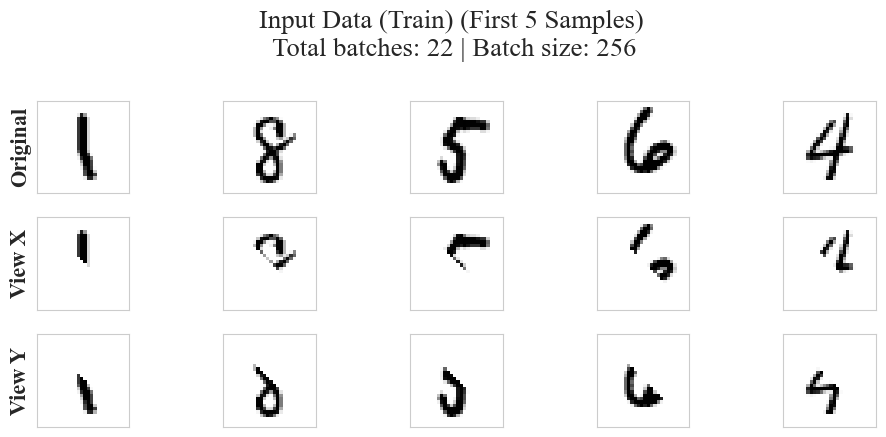

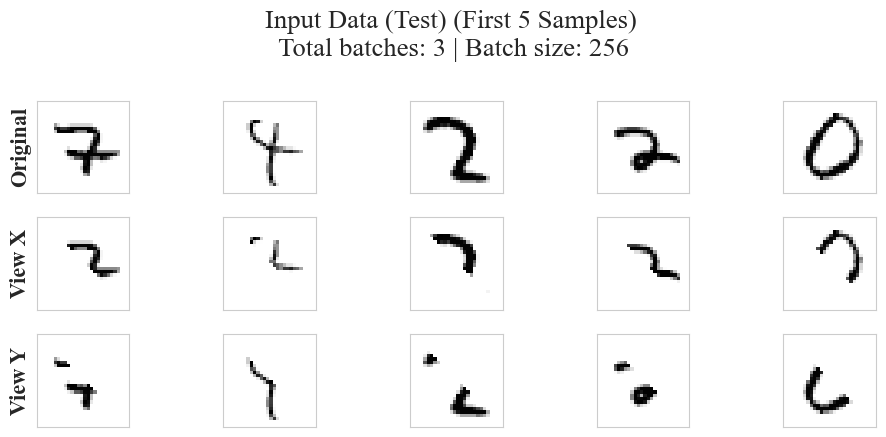

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 64. Best Smoothed Test MI: 4.7299


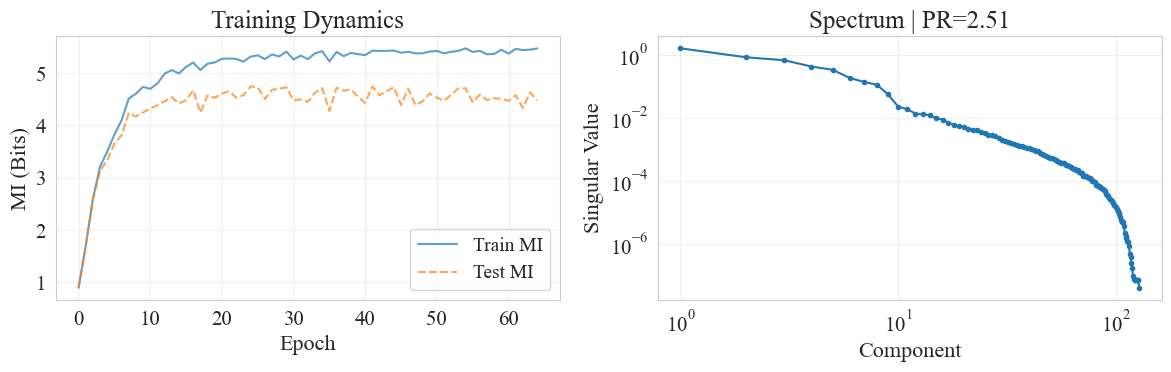

Run completed; saved to temp_finite.h5
✅ Diag_Main Completed. D_eff (Train PR): 2.26

>>> Running Strategy: Diag_Anti
Using device: mps
--- DEBUG MODE ON: Using device mps ---


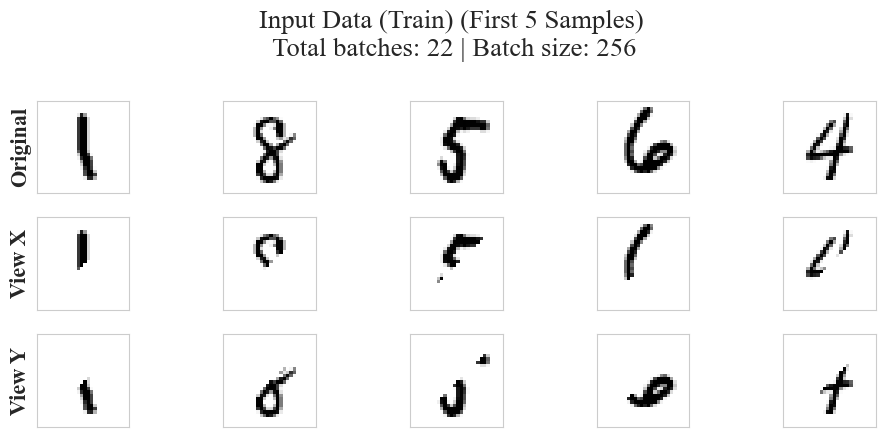

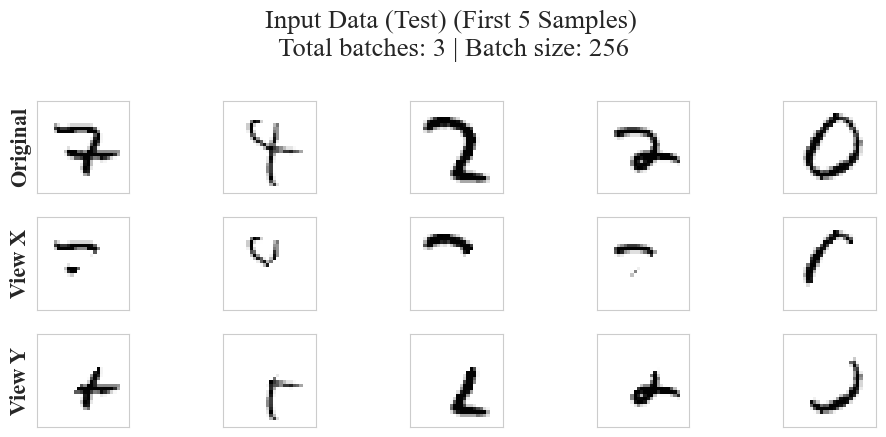

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 51. Best Smoothed Test MI: 4.4948


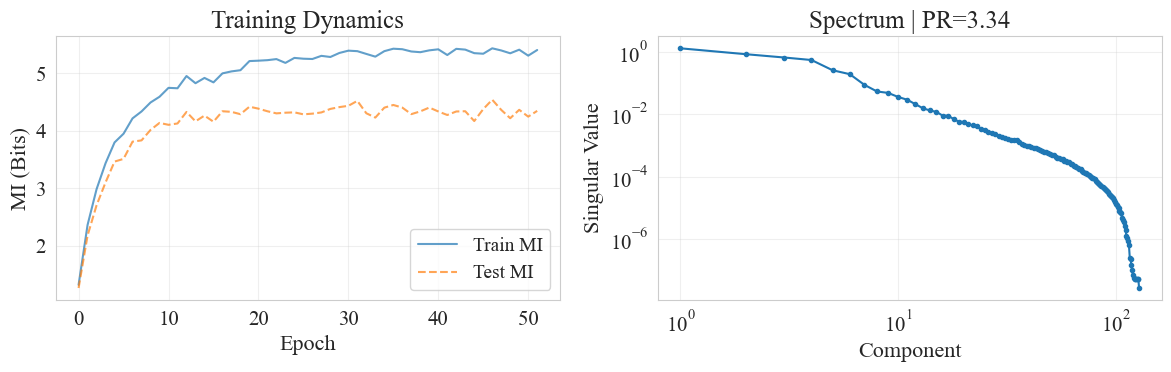

Run completed; saved to temp_finite.h5
✅ Diag_Anti Completed. D_eff (Train PR): 2.91

>>> Running Strategy: Random_50
Using device: mps
--- DEBUG MODE ON: Using device mps ---


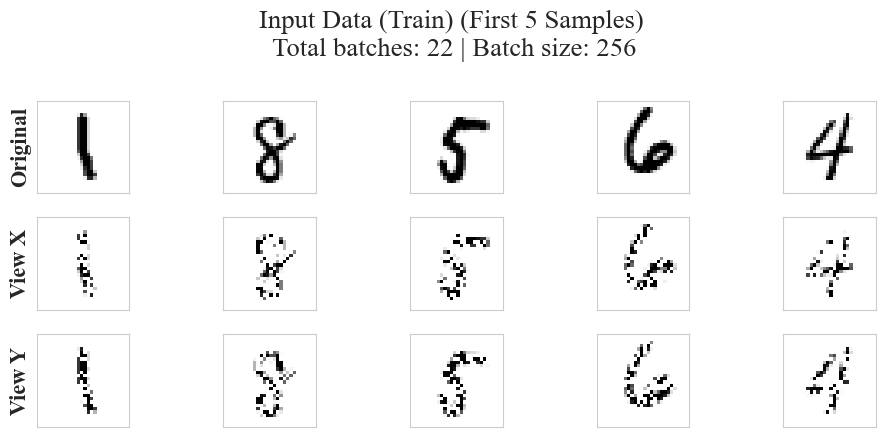

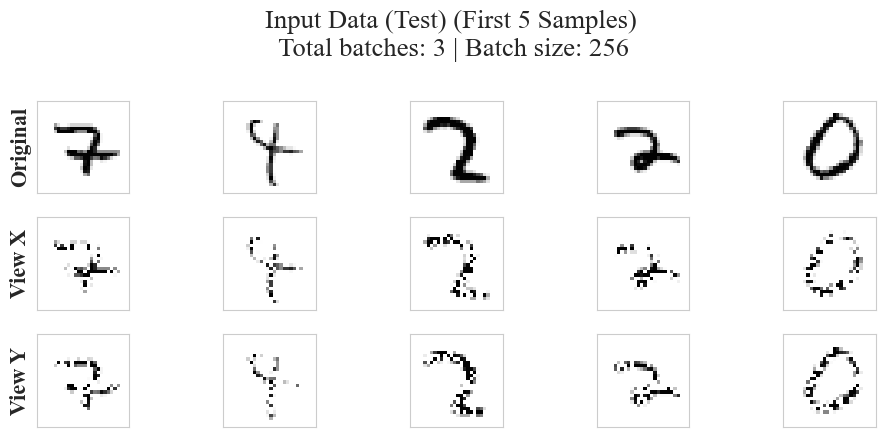

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

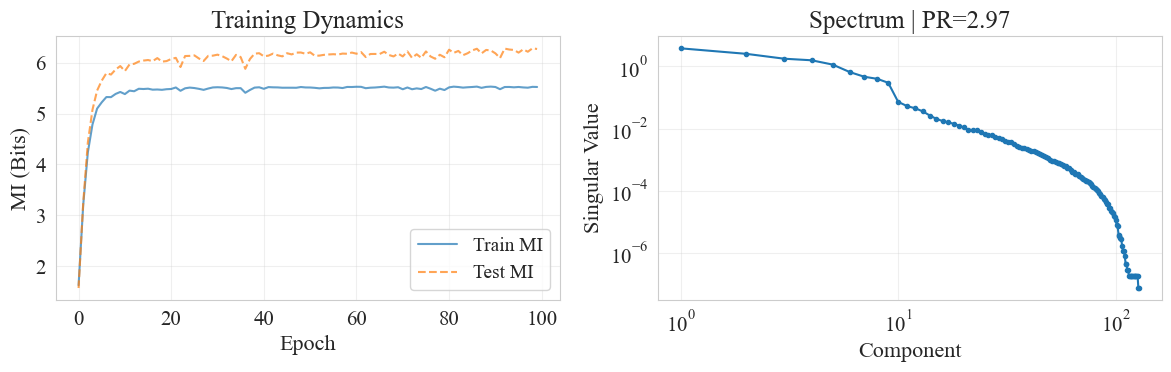

Run completed; saved to temp_finite.h5
✅ Random_50 Completed. D_eff (Train PR): 3.06

--- Final Results ---
     Strategy  Samples     D_eff
0  Horizontal     5000  2.656505
1    Vertical     5000  1.836576
2   Diag_Main     5000  2.263755
3   Diag_Anti     5000  2.906329
4   Random_50     5000  3.063765


In [1]:
import torch
import numpy as np
import pandas as pd
import os
import sys

# Ensure library is in path
sys.path.append(os.getcwd())

from dim_est.run.run_dsib_single_experiment import run_dsib_finite

# --- Configuration ---
DATA_PATH = "mnist_data.pt"
OUTFILE = "temp_finite.h5"
N_SAMPLES = 5000     
N_EPOCHS = 100       
BATCH_SIZE = 256
EMBED_DIM = 128      

# Define the strategies to sweep
strategies = {
    "Horizontal":  {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 2}},
    "Vertical":    {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 1}},
    "Diag_Main":   {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": 1}},
    "Diag_Anti":   {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": -1}},
    "Random_50":   {"split_strategy": "random_feature", "split_params": {"fraction": 0.5, "seed": 42}},
}

def run_estimation_sweep():
    results = []
    
    print(f"--- Starting MNIST ID Estimation (Samples: {N_SAMPLES}) ---")
    
    for name, split_cfg in strategies.items():
        print(f"\n>>> Running Strategy: {name}")
        
        # 1. Setup Overrides
        dataset_overrides = {
            "source": "external",
            "data_path": DATA_PATH,
            "split_strategy": split_cfg["split_strategy"],
            "split_params": split_cfg["split_params"],
        }
        
        training_overrides = {
            "n_epoch": N_EPOCHS,
            "batch_size": BATCH_SIZE,
            "n_samples": N_SAMPLES,
            "eval_train_mode": False,
            "eval_train_mode_final": False,
            "patience": 20,
        }
        
        critic_overrides = {
            "encoder_type": "mlp",
            "embed_dim": EMBED_DIM,
        }
        
        # 2. Run Estimation with DEBUG=True
        try:
            _, _, final_pr, _, _ = run_dsib_finite(
                dataset_type="joint_gaussian", 
                critic_type="hybrid",          
                setup="finite_data_epoch",
                outfile=OUTFILE,
                dataset_overrides=dataset_overrides,
                training_overrides=training_overrides,
                critic_overrides=critic_overrides,
                seed=42,
                debug=True # <--- POP UP VISUALIZATIONS
            )
            
            d_eff = final_pr[0]
            print(f"✅ {name} Completed. D_eff (Train PR): {d_eff:.2f}")
            
            results.append({
                "Strategy": name,
                "Samples": N_SAMPLES,
                "D_eff": d_eff,
            })
            
        except Exception as e:
            print(f"❌ {name} Failed: {e}")
            import traceback
            traceback.print_exc()

    print("\n--- Final Results ---")
    df = pd.DataFrame(results)
    print(df)
    return df

if __name__ == "__main__":
    if not os.path.exists(DATA_PATH):
        print(f"Error: {DATA_PATH} not found.")
    else:
        df_out = run_estimation_sweep()

In [ ]:
import torch
import torchvision
import numpy as np
import pandas as pd
import os
import sys

# Ensure library is in path
sys.path.append(os.getcwd())

from dim_est.run.run_single_experiment import run_finite


DATA_PATH = "mnist_data.pt"

def prepare_mnist(path, max_samples=6000):
    # if os.path.exists(path):
    #     print(f"Data found at {path}")
    #     return
        
    print("Downloading MNIST...")
    ds = torchvision.datasets.MNIST(root="./tmp_data", train=True, download=True, 
                                    transform=torchvision.transforms.ToTensor())
    
    # Select subset for speed
    x = ds.data.float() / 255.0  # (60000, 28, 28)
    x = x.unsqueeze(1)           # (60000, 1, 28, 28)
    
    # Take random subset
    indices = torch.randperm(len(x))[:max_samples]
    x_subset = x[indices]
    
    torch.save(x_subset, path)
    print(f"Saved {len(x_subset)} samples to {path}")

# --- Configuration ---
DATA_PATH = "mnist_data.pt"
OUTFILE = "temp_finite.h5"
N_EPOCHS = 100        
BATCH_SIZE = 256
EMBED_DIM = 128       


# Define the strategies
strategies = {
    "Horizontal":  {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 2}},
    "Vertical":    {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 1}},
    "Diag_Main":   {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": 1}},
    "Diag_Anti":   {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": -1}},
    "Random_50":   {"split_strategy": "random_feature", "split_params": {"fraction": 0.5, "seed": 42}},
}

# Define sample sizes to sweep: 2^10 to 2^13 (1024 to 8192)
sample_sizes = np.logspace(10, 13, num=4, dtype=int, base=2)


def run_estimation_sweep():
    # Ensure Output Directory Exists
    os.makedirs(os.path.dirname(OUTFILE) if os.path.dirname(OUTFILE) else ".", exist_ok=True)
    
    results = []
    
    print(f"--- Starting MNIST ID Estimation Sweep ---")
    print(f"Sample Sizes: {sample_sizes}")
    
    for n_samples in sample_sizes:
        print(f"\n==========================================")
        print(f"   Testing Sample Size: {n_samples}")
        prepare_mnist(DATA_PATH, max_samples=n_samples)
        print(f"==========================================")
        
        for name, split_cfg in strategies.items():
            print(f">>> Running Strategy: {name}")
            
            # 1. Setup Overrides
            dataset_overrides = {
                "source": "external",
                "data_path": DATA_PATH,
                "split_strategy": split_cfg["split_strategy"],
                "split_params": split_cfg["split_params"],
            }
            
            # Training: update n_samples dynamically
            training_overrides = {
                "n_epoch": N_EPOCHS,
                "batch_size": BATCH_SIZE,
                "n_samples": int(n_samples), # Ensure standard Python int
                "eval_train_mode": BATCH_SIZE,
                "eval_train_mode_final": False,
                "patience": 20,
            }
            
            critic_overrides = {
                "encoder_type": "mlp",
                "embed_dim": EMBED_DIM,
            }
            
            # 2. Run Estimation
            try:
                running_mi, _, final_pr, _, _ = run_finite(
                    dataset_type="joint_gaussian", 
                    critic_type="hybrid",          
                    setup="finite_data_epoch",
                    outfile=OUTFILE,
                    estimator='smile_5',
                    dataset_overrides=dataset_overrides,
                    training_overrides=training_overrides,
                    critic_overrides=critic_overrides,
                    seed=42
                )
                
                # Extract Train PR (D_eff) and MI information
                d_eff = final_pr[0]
                mi = running_mi[0][np.argmax(running_mi[1])]
                
                print(f"✅ {name} (N={n_samples}) -> D_eff: {d_eff:.2f}, MI: {mi:.2f}")
                
                results.append({
                    "Strategy": name,
                    "Samples": n_samples,
                    "D_eff": d_eff,
                    "MI": mi
                })
                
            except Exception as e:
                print(f"❌ {name} (N={n_samples}) Failed: {e}")
                # Optional: print traceback if needed for deep debugging
                # import traceback
                # traceback.print_exc()

    # 3. Summary
    print("\n--- Final Results ---")
    df = pd.DataFrame(results)
    print(df)
    
    # Save results to CSV for easy plotting later
    # df.to_csv("mnist_sample_sweep_results.csv", index=False)
    return df

In [3]:
df_out_smile = run_estimation_sweep()

--- Starting MNIST ID Estimation Sweep ---
Sample Sizes: [1024 2048 4096 8192]

   Testing Sample Size: 1024
Saved 1024 samples to mnist_data.pt
>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 38. Best Smoothed Test MI: 1.8830
Run completed; saved to temp_finite.h5
✅ Horizontal (N=1024) -> D_eff: 1.16, MI: 4.98
>>> Running Strategy: Vertical
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 40. Best Smoothed Test MI: 1.6587
Run completed; saved to temp_finite.h5
✅ Vertical (N=1024) -> D_eff: 1.15, MI: 5.15
>>> Running Strategy: Diag_Main
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 39. Best Smoothed Test MI: 1.7519
Run completed; saved to temp_finite.h5
✅ Diag_Main (N=1024) -> D_eff: 1.08, MI: 4.66
>>> Running Strategy: Diag_Anti
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 43. Best Smoothed Test MI: 1.8050
Run completed; saved to temp_finite.h5
✅ Diag_Anti (N=1024) -> D_eff: 1.12, MI: 5.18
>>> Running Strategy: Random_50
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 57. Best Smoothed Test MI: 3.4369
Run completed; saved to temp_finite.h5
✅ Random_50 (N=1024) -> D_eff: 1.06, MI: 10.50

   Testing Sample Size: 2048
Saved 2048 samples to mnist_data.pt
>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 39. Best Smoothed Test MI: 2.6910
Run completed; saved to temp_finite.h5
✅ Horizontal (N=2048) -> D_eff: 1.79, MI: 5.90
>>> Running Strategy: Vertical
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 41. Best Smoothed Test MI: 2.0751
Run completed; saved to temp_finite.h5
✅ Vertical (N=2048) -> D_eff: 1.39, MI: 5.45
>>> Running Strategy: Diag_Main
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 46. Best Smoothed Test MI: 2.5090
Run completed; saved to temp_finite.h5
✅ Diag_Main (N=2048) -> D_eff: 1.40, MI: 6.97
>>> Running Strategy: Diag_Anti
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 52. Best Smoothed Test MI: 2.4637
Run completed; saved to temp_finite.h5
✅ Diag_Anti (N=2048) -> D_eff: 1.62, MI: 6.82
>>> Running Strategy: Random_50
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Run completed; saved to temp_finite.h5
✅ Random_50 (N=2048) -> D_eff: 1.58, MI: 14.19

   Testing Sample Size: 4096
Saved 4096 samples to mnist_data.pt
>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 62. Best Smoothed Test MI: 3.8173
Run completed; saved to temp_finite.h5
✅ Horizontal (N=4096) -> D_eff: 2.33, MI: 8.53
>>> Running Strategy: Vertical
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 49. Best Smoothed Test MI: 3.6616
Run completed; saved to temp_finite.h5
✅ Vertical (N=4096) -> D_eff: 1.55, MI: 7.46
>>> Running Strategy: Diag_Main
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 75. Best Smoothed Test MI: 4.2795
Run completed; saved to temp_finite.h5
✅ Diag_Main (N=4096) -> D_eff: 2.05, MI: 9.71
>>> Running Strategy: Diag_Anti
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 95. Best Smoothed Test MI: 4.1614
Run completed; saved to temp_finite.h5
✅ Diag_Anti (N=4096) -> D_eff: 3.03, MI: 9.21
>>> Running Strategy: Random_50
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Run completed; saved to temp_finite.h5
✅ Random_50 (N=4096) -> D_eff: 2.95, MI: 15.07

   Testing Sample Size: 8192
Saved 8192 samples to mnist_data.pt
>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Run completed; saved to temp_finite.h5
✅ Horizontal (N=8192) -> D_eff: 3.47, MI: 10.62
>>> Running Strategy: Vertical
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Run completed; saved to temp_finite.h5
✅ Vertical (N=8192) -> D_eff: 2.40, MI: 10.10
>>> Running Strategy: Diag_Main
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Run completed; saved to temp_finite.h5
✅ Diag_Main (N=8192) -> D_eff: 2.63, MI: 10.82
>>> Running Strategy: Diag_Anti
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 71. Best Smoothed Test MI: 5.3071
Run completed; saved to temp_finite.h5
✅ Diag_Anti (N=8192) -> D_eff: 2.67, MI: 10.34
>>> Running Strategy: Random_50
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Run completed; saved to temp_finite.h5
✅ Random_50 (N=8192) -> D_eff: 2.43, MI: 14.81

--- Final Results ---
      Strategy  Samples     D_eff         MI
0   Horizontal     1024  1.161403   4.983945
1     Vertical     1024  1.150620   5.151986
2    Diag_Main     1024  1.079786   4.661859
3    Diag_Anti     1024  1.123130   5.183179
4    Random_50     1024  1.060032  10.498046
5   Horizontal     2048  1.793517   5.902626
6     Vertical     2048  1.393956   5.446384
7    Diag_Main     2048  1.397312   6.965797
8    Diag_Anti     2048  1.618930   6.820411
9    Random_50     2048  1.579197  14.188797
10  Horizontal     4096  2.329990   8.534518
11    Vertical     4096  1.553971   7.464003
12   Diag_Main     4096  2.046419   9.713476
13   Diag_Anti     4096  3.029312   9.214456
14   Random_50     4096  2.947446  15.072368
15  Horizontal     8192  3.470477  10.615131
16    Vertical     8192  2.401475  10.095914
17   Diag_Main     8192  2.625513  10.816036
18   Diag_Anti     8192  2.670791  1

In [8]:
def plot_results(df_out, title="Splitting Strategy"):

    import matplotlib.pyplot as plt
    import seaborn as sns
    import matplotlib.ticker as ticker

    # 1. Create side-by-side subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

    # 2. Plot D_eff on the first axis
    sns.lineplot(
        data=df_out, x="Samples", y="D_eff", hue="Strategy", style="Strategy", 
        markers=True, dashes=False, linewidth=2.5, palette="tab10", ax=ax1,
        legend=False  # Disable internal legend
    )
    ax1.set_xscale('log', base=2)
    ax1.set_ylabel("Estimated Intrinsic Dim ($D_{eff}$)")
    ax1.set_title("$D_{eff}$ vs. Sample Size")
    # ax1.set_ylim(-0.5, 7)

    # 3. Plot MI on the second axis
    sns.lineplot(
        data=df_out, x="Samples", y="MI", hue="Strategy", style="Strategy", 
        markers=True, dashes=False, linewidth=2.5, palette="tab10", ax=ax2,
        legend=True  # We will extract handles from this one
    )
    ax2.set_xscale('log', base=2)
    ax2.set_ylabel("Mutual Information (MI)")
    ax2.set_title("MI vs. Sample Size")
    ax2.set_ylim(-0.5, max(df_out["MI"].max(), df_out["MI"].max()) * 1.1)

    # 4. Format X-axes
    for ax in [ax1, ax2]:
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
        ax.grid(True, which="both", linestyle='--', alpha=0.7)

    # 5. Extract handles and labels for the shared legend
    handles, labels = ax2.get_legend_handles_labels()
    ax2.get_legend().remove() # Remove the legend from the plot area

    # 6. Create the horizontal shared legend above the subplots
    fig.legend(
        handles, labels, 
        loc='upper center', 
        bbox_to_anchor=(0.5, 1.07), # Positioned above the subplots
        ncol=len(labels),           # Horizontal layout
        title=title
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust figure to fit the legend
    plt.show()


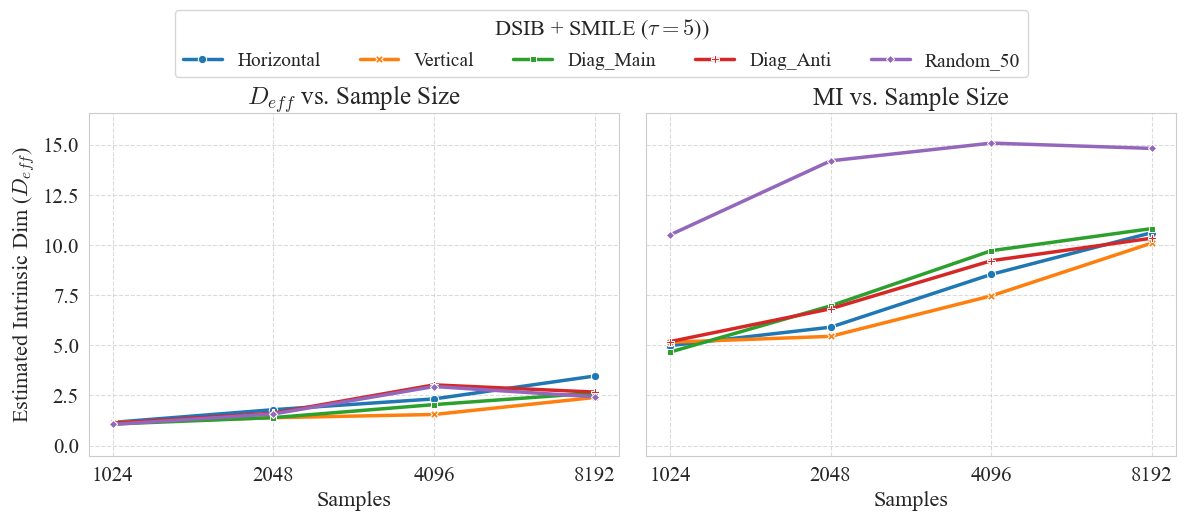

In [5]:
plot_results(df_out_smile, title=r"DSIB + SMILE ($\tau = 5$))")

In [3]:
import torch
import torchvision
import numpy as np
import pandas as pd
import os
import sys

# Ensure library is in path
sys.path.append(os.getcwd())

from dim_est.run.run_single_experiment import run_finite


def run_full_experiment(estimator_name="smile_5", model="dsib"):
    DATA_PATH = "mnist_data.pt"

    def prepare_mnist(path, max_samples=6000):
        # if os.path.exists(path):
        #     print(f"Data found at {path}")
        #     return
            
        print("Downloading MNIST...")
        ds = torchvision.datasets.MNIST(root="./tmp_data", train=True, download=True, 
                                        transform=torchvision.transforms.ToTensor())
        
        # Select subset for speed
        x = ds.data.float() / 255.0  # (60000, 28, 28)
        x = x.unsqueeze(1)           # (60000, 1, 28, 28)
        
        # Take random subset
        indices = torch.randperm(len(x))[:max_samples]
        x_subset = x[indices]
        
        torch.save(x_subset, path)
        print(f"Saved {len(x_subset)} samples to {path}")

    # --- Configuration ---
    DATA_PATH = "mnist_data.pt"
    OUTFILE = "temp_finite.h5"
    N_EPOCHS = 100        
    BATCH_SIZE = 256
    EMBED_DIM = 128       


    # Define the strategies
    strategies = {
        "Horizontal":  {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 2}},
        "Vertical":    {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 1}},
        "Diag_Main":   {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": 1}},
        "Diag_Anti":   {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": -1}},
        "Random_50":   {"split_strategy": "random_feature", "split_params": {"fraction": 0.5, "seed": 42}},
    }

    # Define sample sizes to sweep: 2^10 to 2^13 (1024 to 8192)
    sample_sizes = np.logspace(10, 13, num=4, dtype=int, base=2)


    def run_estimation_sweep():
        # Ensure Output Directory Exists
        os.makedirs(os.path.dirname(OUTFILE) if os.path.dirname(OUTFILE) else ".", exist_ok=True)
        
        results = []
        
        print(f"--- Starting MNIST ID Estimation Sweep ---")
        print(f"Sample Sizes: {sample_sizes}")
        
        for n_samples in sample_sizes:
            print(f"\n==========================================")
            print(f"   Testing Sample Size: {n_samples}")
            prepare_mnist(DATA_PATH, max_samples=n_samples)
            print(f"==========================================")
            
            for name, split_cfg in strategies.items():
                print(f">>> Running Strategy: {name}")
                
                # 1. Setup Overrides
                dataset_overrides = {
                    "source": "external",
                    "data_path": DATA_PATH,
                    "split_strategy": split_cfg["split_strategy"],
                    "split_params": split_cfg["split_params"],
                }
                
                # Training: update n_samples dynamically
                training_overrides = {
                    "n_epoch": N_EPOCHS,
                    "batch_size": BATCH_SIZE,
                    "n_samples": int(n_samples), # Ensure standard Python int
                    "eval_train_mode": BATCH_SIZE,
                    "eval_train_mode_final": False,
                    "patience": 20,
                    "show_progress": True,
                }
                
                critic_overrides = {
                    "encoder_type": "mlp",
                    "embed_dim": EMBED_DIM,
                }

                model_overrides = {
                    "model_type": model,
                    # "params": {"beta": 4096},
                }
                
                # 2. Run Estimation
                try:
                    running_mi, _, final_pr, _, _ = run_finite(
                        dataset_type="joint_gaussian", 
                        critic_type="hybrid",          
                        setup="finite_data_epoch",
                        outfile=OUTFILE,
                        estimator=estimator_name,
                        dataset_overrides=dataset_overrides,
                        training_overrides=training_overrides,
                        critic_overrides=critic_overrides,
                        model_overrides=model_overrides,
                        seed=42
                    )
                    
                    # Extract Train PR (D_eff) and MI information
                    d_eff = final_pr[0]
                    mi = running_mi[0][np.argmax(running_mi[1])]
                    
                    print(f"✅ {name} (N={n_samples}) -> D_eff: {d_eff:.2f}, MI: {mi:.2f}")
                    
                    results.append({
                        "Strategy": name,
                        "Samples": n_samples,
                        "D_eff": d_eff,
                        "MI": mi
                    })
                    
                except Exception as e:
                    print(f"❌ {name} (N={n_samples}) Failed: {e}")
                    # Optional: print traceback if needed for deep debugging
                    # import traceback
                    # traceback.print_exc()

        # 3. Summary
        print("\n--- Final Results ---")
        df = pd.DataFrame(results)
        print(df)
        
        # Save results to CSV for easy plotting later
        # df.to_csv("mnist_sample_sweep_results.csv", index=False)
        return df
    df_out = run_estimation_sweep()
    return df_out

In [ ]:
lclip_dsib = run_full_experiment(estimator_name="lclip", model="dsib")
smile_dsib = run_full_experiment(estimator_name="smile_5", model="dsib")
lclip_dvsib = run_full_experiment(estimator_name="lclip", model="dvsib")
smile_dvsib = run_full_experiment(estimator_name="smile_5", model="dvsib")

--- Starting MNIST ID Estimation Sweep ---
Sample Sizes: [1024 2048 4096 8192]

   Testing Sample Size: 1024
Saved 1024 samples to mnist_data.pt
>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 36. Best Smoothed Test MI: 2.3522
Run completed; saved to temp_finite.h5
✅ Horizontal (N=1024) -> D_eff: 1.68, MI: 6.23
>>> Running Strategy: Vertical
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 38. Best Smoothed Test MI: 2.0066
Run completed; saved to temp_finite.h5
✅ Vertical (N=1024) -> D_eff: 1.29, MI: 6.26
>>> Running Strategy: Diag_Main
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 43. Best Smoothed Test MI: 2.3602
Run completed; saved to temp_finite.h5
✅ Diag_Main (N=1024) -> D_eff: 1.38, MI: 7.35
>>> Running Strategy: Diag_Anti
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 43. Best Smoothed Test MI: 2.3696
Run completed; saved to temp_finite.h5
✅ Diag_Anti (N=1024) -> D_eff: 1.52, MI: 7.04
>>> Running Strategy: Random_50
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 47. Best Smoothed Test MI: 3.9022
Run completed; saved to temp_finite.h5
✅ Random_50 (N=1024) -> D_eff: 1.18, MI: 7.91

   Testing Sample Size: 2048
Saved 2048 samples to mnist_data.pt
>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 36. Best Smoothed Test MI: 3.3039
Run completed; saved to temp_finite.h5
✅ Horizontal (N=2048) -> D_eff: 2.20, MI: 6.92
>>> Running Strategy: Vertical
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 34. Best Smoothed Test MI: 3.0202
Run completed; saved to temp_finite.h5
✅ Vertical (N=2048) -> D_eff: 1.75, MI: 6.17
>>> Running Strategy: Diag_Main
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 41. Best Smoothed Test MI: 3.2439
Run completed; saved to temp_finite.h5
✅ Diag_Main (N=2048) -> D_eff: 1.85, MI: 7.36
>>> Running Strategy: Diag_Anti
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 37. Best Smoothed Test MI: 3.0719
Run completed; saved to temp_finite.h5
✅ Diag_Anti (N=2048) -> D_eff: 2.23, MI: 7.16
>>> Running Strategy: Random_50
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Run completed; saved to temp_finite.h5
✅ Random_50 (N=2048) -> D_eff: 2.03, MI: 7.99

   Testing Sample Size: 4096
Saved 4096 samples to mnist_data.pt
>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 42. Best Smoothed Test MI: 3.9693
Run completed; saved to temp_finite.h5
✅ Horizontal (N=4096) -> D_eff: 2.70, MI: 7.66
>>> Running Strategy: Vertical
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 35. Best Smoothed Test MI: 3.7307
Run completed; saved to temp_finite.h5
✅ Vertical (N=4096) -> D_eff: 1.90, MI: 7.02
>>> Running Strategy: Diag_Main
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 43. Best Smoothed Test MI: 4.2786
Run completed; saved to temp_finite.h5
✅ Diag_Main (N=4096) -> D_eff: 2.05, MI: 7.74
>>> Running Strategy: Diag_Anti
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 45. Best Smoothed Test MI: 4.1276
Run completed; saved to temp_finite.h5
✅ Diag_Anti (N=4096) -> D_eff: 2.65, MI: 7.67
>>> Running Strategy: Random_50
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 85. Best Smoothed Test MI: 5.8619
Run completed; saved to temp_finite.h5
✅ Random_50 (N=4096) -> D_eff: 2.93, MI: 7.97

   Testing Sample Size: 8192
Saved 8192 samples to mnist_data.pt
>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 42. Best Smoothed Test MI: 5.0835
Run completed; saved to temp_finite.h5
✅ Horizontal (N=8192) -> D_eff: 2.56, MI: 7.79
>>> Running Strategy: Vertical
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 38. Best Smoothed Test MI: 4.4451
Run completed; saved to temp_finite.h5
✅ Vertical (N=8192) -> D_eff: 1.95, MI: 7.45
>>> Running Strategy: Diag_Main
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 73. Best Smoothed Test MI: 5.3283
Run completed; saved to temp_finite.h5
✅ Diag_Main (N=8192) -> D_eff: 2.79, MI: 7.86
>>> Running Strategy: Diag_Anti
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

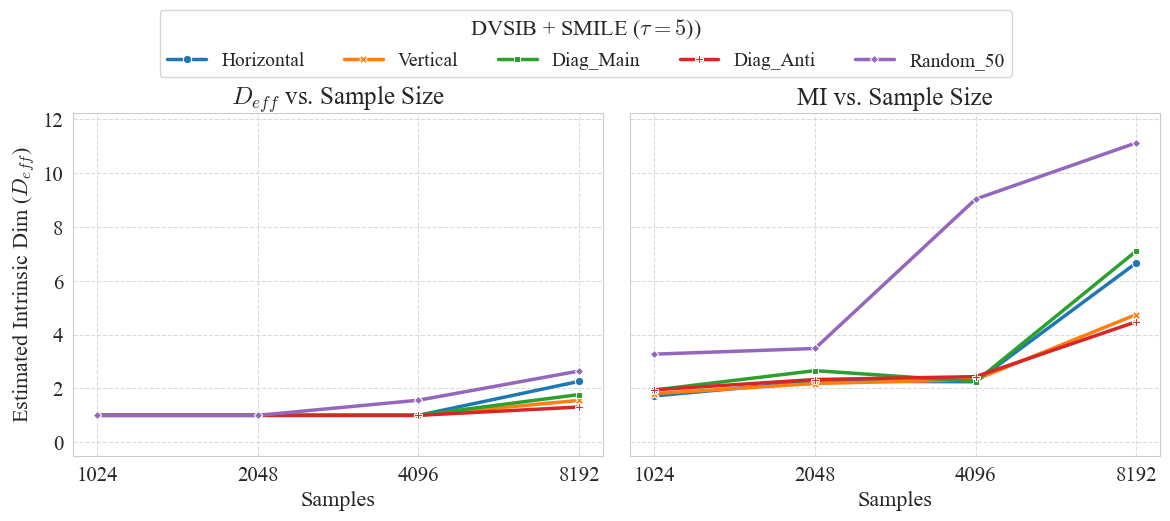

In [ ]:
plot_results(lclip_dsib, title=r"DSIB + LCLIP")
plot_results(lclip_dvsib, title=r"DVSIB + LCLIP")
plot_results(smile_dsib, title=r"DSIB + SMILE ($\tau = 5$))")
plot_results(smile_dvsib, title=r"DVSIB + SMILE ($\tau = 5$))")

--- Starting MNIST ID Estimation (Samples: 5000) ---

>>> Running Strategy: Horizontal
Using device: mps
--- DEBUG MODE ON: Using device mps ---


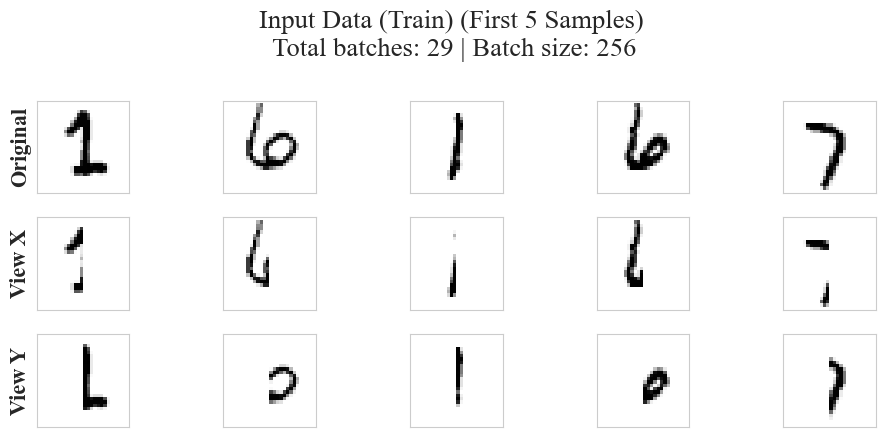

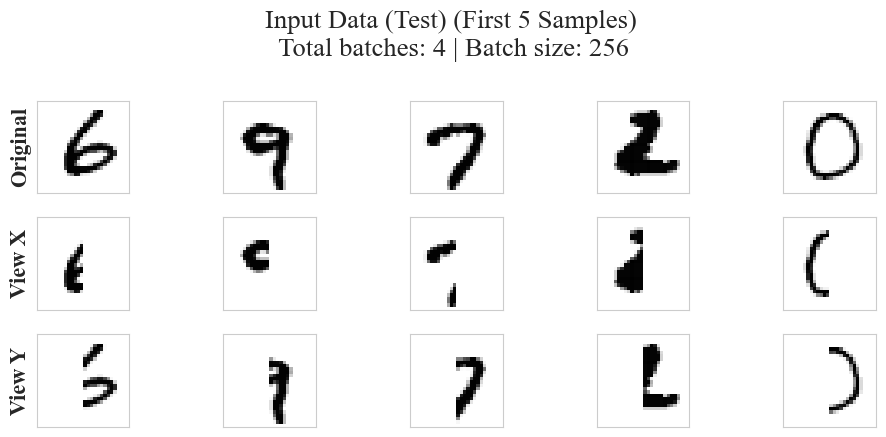

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 55. Best Smoothed Test MI: 4.9467


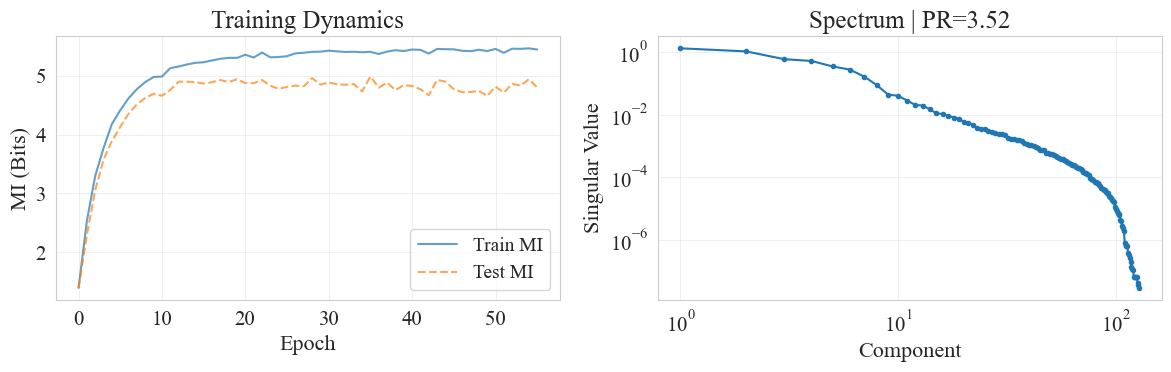

Run completed; saved to temp_finite.h5
✅ Horizontal Completed. D_eff (Train PR): 3.07

>>> Running Strategy: Vertical
Using device: mps
--- DEBUG MODE ON: Using device mps ---


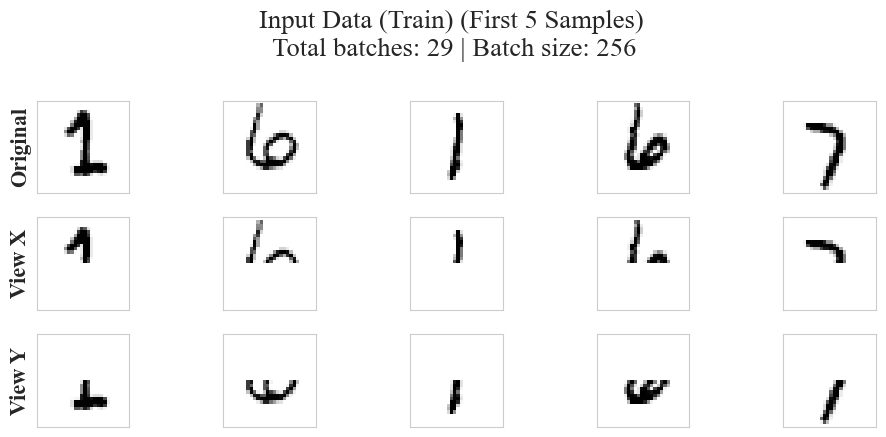

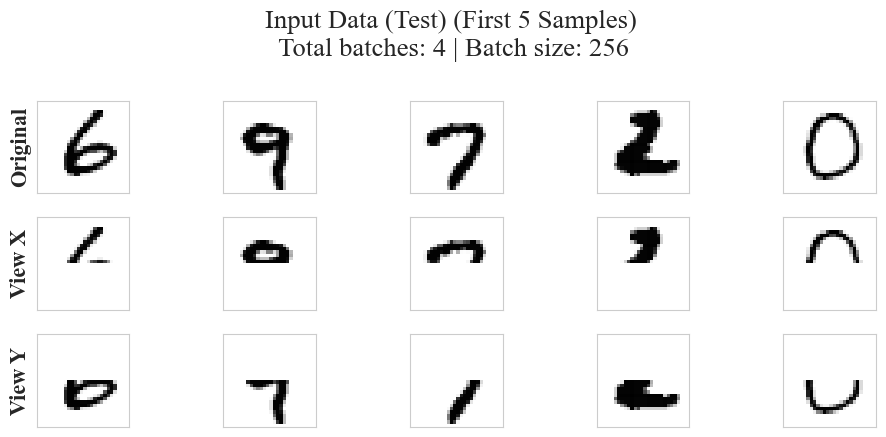

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 36. Best Smoothed Test MI: 4.4629


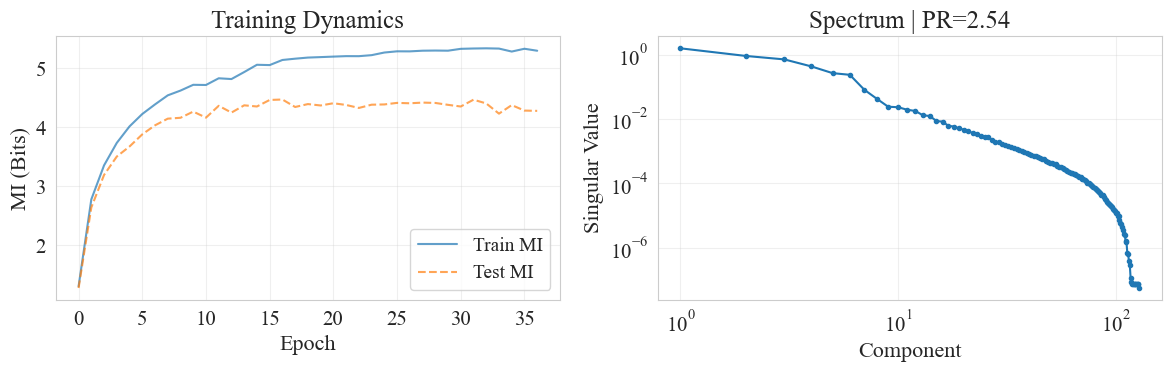

Run completed; saved to temp_finite.h5
✅ Vertical Completed. D_eff (Train PR): 2.41

>>> Running Strategy: Diag_Main
Using device: mps
--- DEBUG MODE ON: Using device mps ---


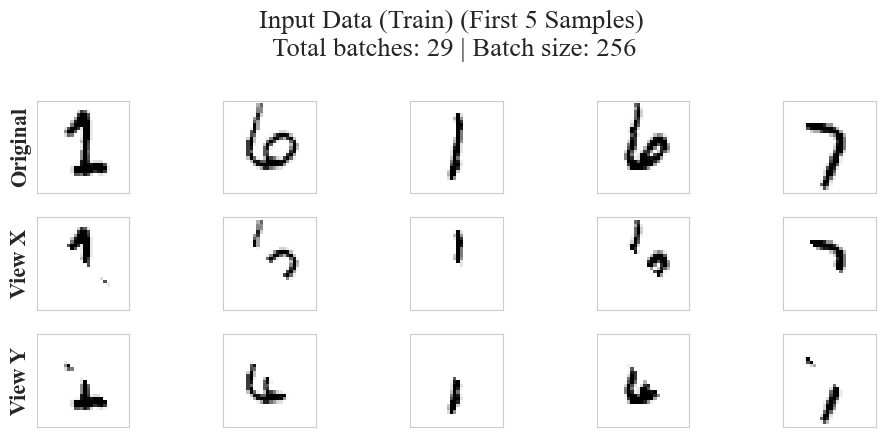

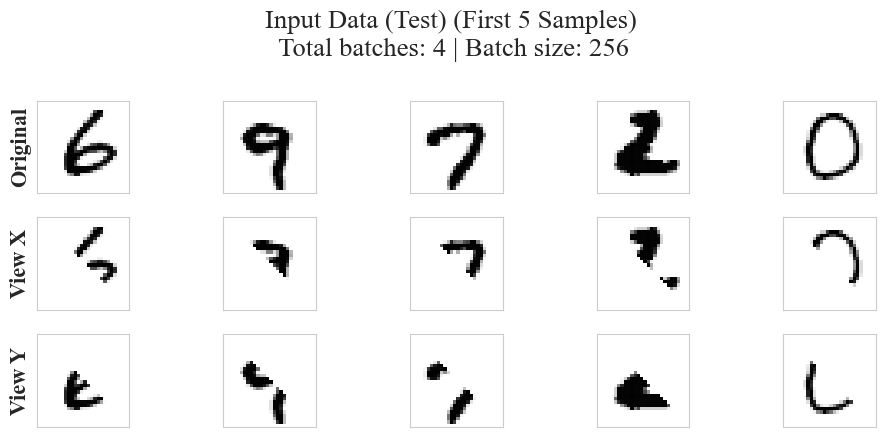

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 67. Best Smoothed Test MI: 5.0757


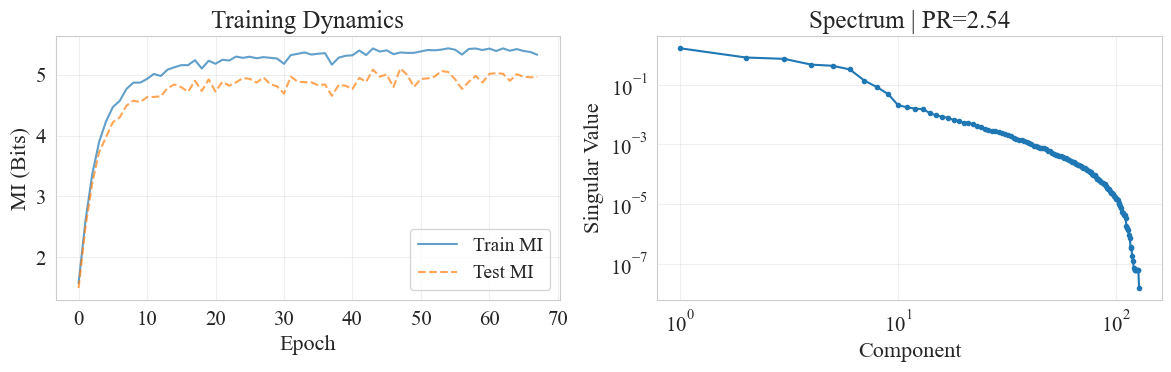

Run completed; saved to temp_finite.h5
✅ Diag_Main Completed. D_eff (Train PR): 2.41

>>> Running Strategy: Diag_Anti
Using device: mps
--- DEBUG MODE ON: Using device mps ---


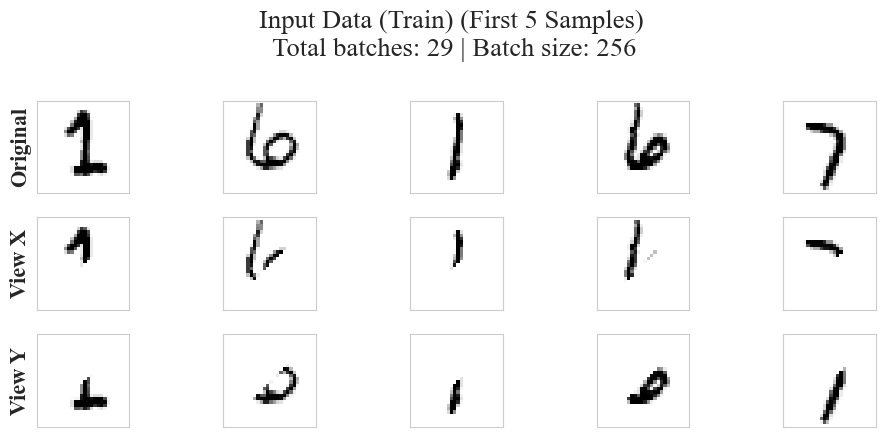

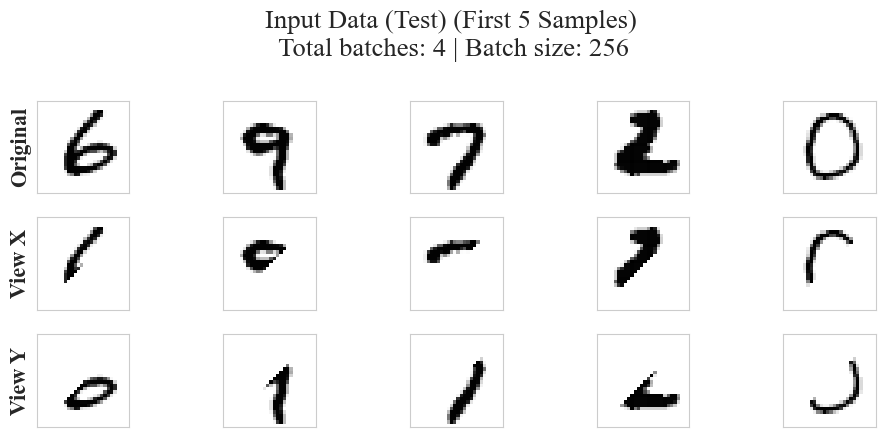

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 42. Best Smoothed Test MI: 4.8626


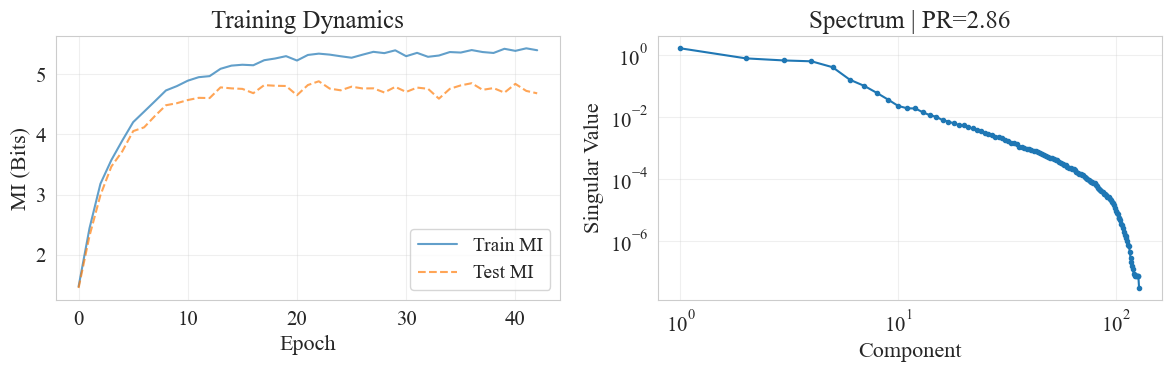

Run completed; saved to temp_finite.h5
✅ Diag_Anti Completed. D_eff (Train PR): 2.36

>>> Running Strategy: Random_50
Using device: mps
--- DEBUG MODE ON: Using device mps ---


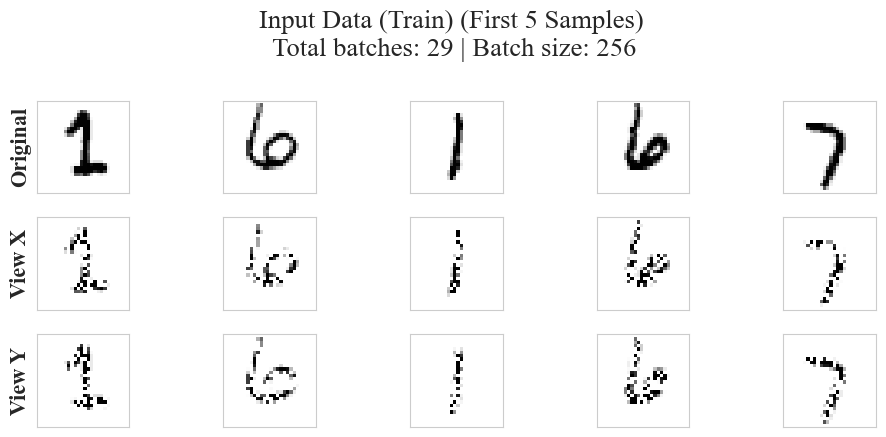

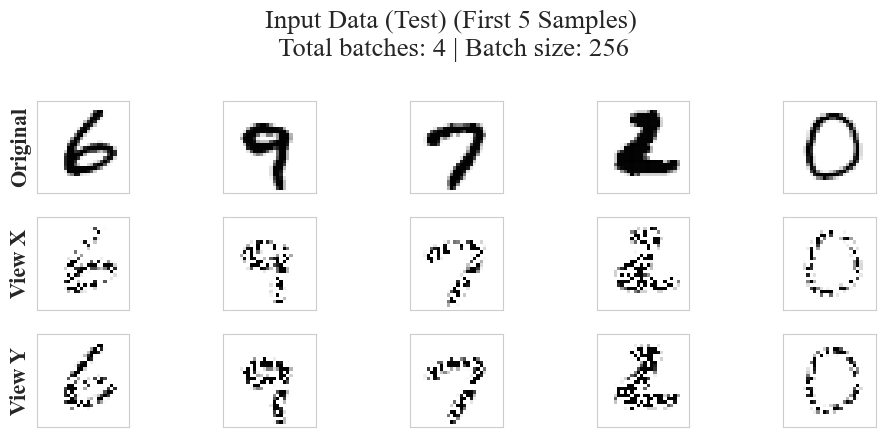

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 80. Best Smoothed Test MI: 6.6178


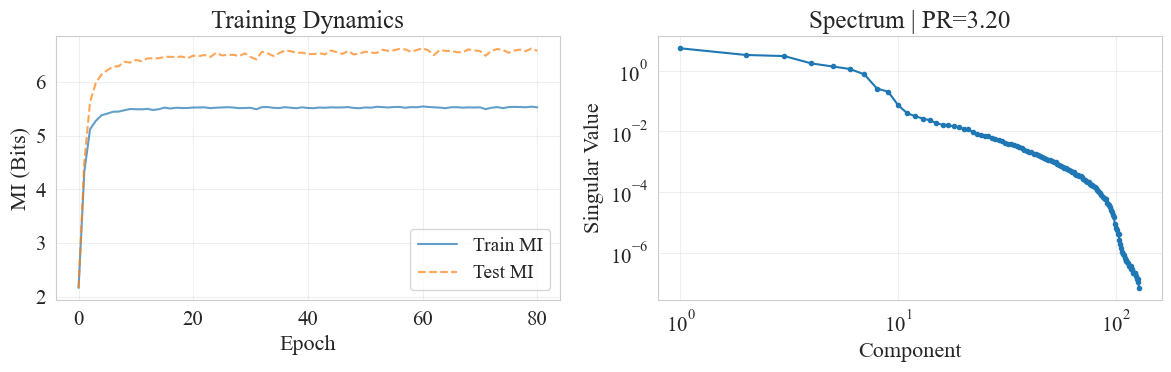

Run completed; saved to temp_finite.h5
✅ Random_50 Completed. D_eff (Train PR): 2.91

--- Final Results ---
     Strategy  Samples     D_eff
0  Horizontal     5000  3.070242
1    Vertical     5000  2.406770
2   Diag_Main     5000  2.410850
3   Diag_Anti     5000  2.355768
4   Random_50     5000  2.908803


In [2]:
import torch
import numpy as np
import pandas as pd
import os
import sys

# Ensure library is in path
sys.path.append(os.getcwd())

from dim_est.run.run_single_experiment import run_finite

# --- Configuration ---
DATA_PATH = "mnist_data.pt"
OUTFILE = "temp_finite.h5"
N_SAMPLES = 5000     
N_EPOCHS = 100       
BATCH_SIZE = 256
EMBED_DIM = 128      

# Define the strategies to sweep
strategies = {
    "Horizontal":  {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 2}},
    "Vertical":    {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 1}},
    "Diag_Main":   {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": 1}},
    "Diag_Anti":   {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": -1}},
    "Random_50":   {"split_strategy": "random_feature", "split_params": {"fraction": 0.5, "seed": 42}},
}

def run_estimation_sweep():
    results = []
    
    print(f"--- Starting MNIST ID Estimation (Samples: {N_SAMPLES}) ---")
    
    for name, split_cfg in strategies.items():
        print(f"\n>>> Running Strategy: {name}")
        
        # 1. Setup Overrides
        dataset_overrides = {
            "source": "external",
            "data_path": DATA_PATH,
            "split_strategy": split_cfg["split_strategy"],
            "split_params": split_cfg["split_params"],
        }
        
        training_overrides = {
            "n_epoch": N_EPOCHS,
            "batch_size": BATCH_SIZE,
            "n_samples": N_SAMPLES,
            "eval_train_mode": False,
            "eval_train_mode_final": False,
            "patience": 20,
        }
        
        critic_overrides = {
            "encoder_type": "mlp",
            "embed_dim": EMBED_DIM,
        }
        
        # 2. Run Estimation with DEBUG=True
        try:
            _, _, final_pr, _, _ = run_finite(
                dataset_type="joint_gaussian", 
                critic_type="hybrid",          
                setup="finite_data_epoch",
                outfile=OUTFILE,
                dataset_overrides=dataset_overrides,
                training_overrides=training_overrides,
                critic_overrides=critic_overrides,
                seed=42,
                debug=True # <--- POP UP VISUALIZATIONS
            )
            
            d_eff = final_pr[0]
            print(f"✅ {name} Completed. D_eff (Train PR): {d_eff:.2f}")
            
            results.append({
                "Strategy": name,
                "Samples": N_SAMPLES,
                "D_eff": d_eff,
            })
            
        except Exception as e:
            print(f"❌ {name} Failed: {e}")
            import traceback
            traceback.print_exc()

    print("\n--- Final Results ---")
    df = pd.DataFrame(results)
    print(df)
    return df

if __name__ == "__main__":
    if not os.path.exists(DATA_PATH):
        print(f"Error: {DATA_PATH} not found.")
    else:
        df_out = run_estimation_sweep()

In [ ]:
0  Horizontal     5000  3.119938
1    Vertical     5000  2.355580
2   Diag_Main     5000  2.446718
3   Diag_Anti     5000  2.449015
4   Random_50     5000  2.750395


--- Starting MNIST ID Estimation (Samples: 5000) ---

>>> Running Strategy: Horizontal
Using device: mps
--- DEBUG MODE ON: Using device mps ---


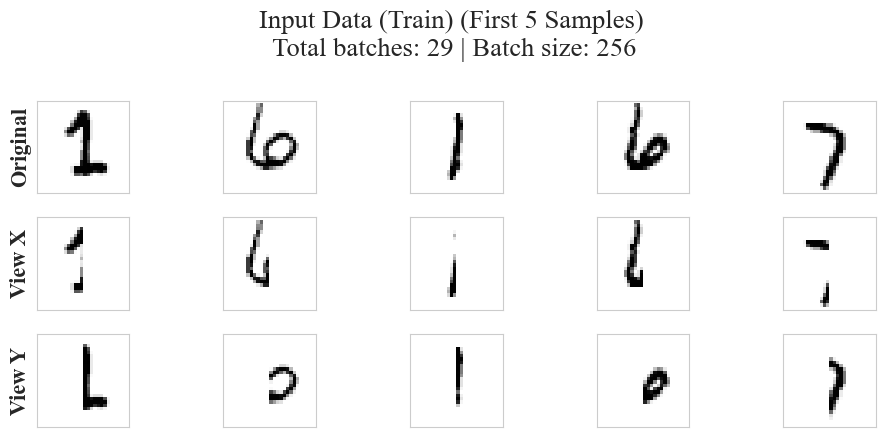

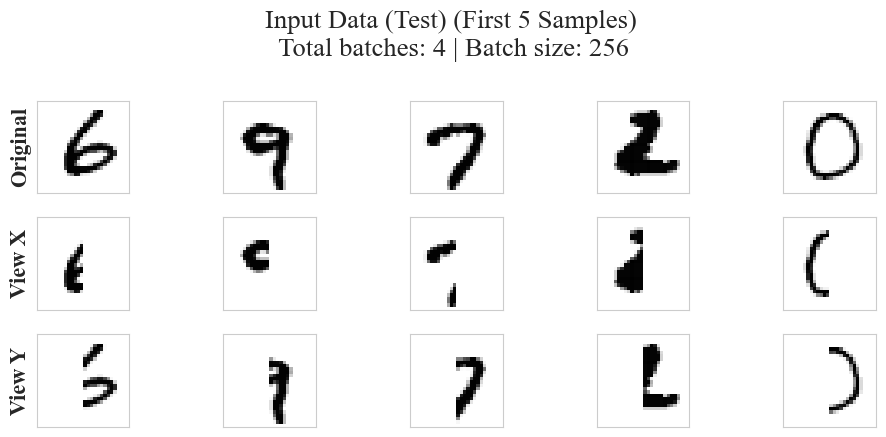

Model is DVSIB: Using variational=True, beta=2048.0


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 58. Best Smoothed Test MI: 4.9624


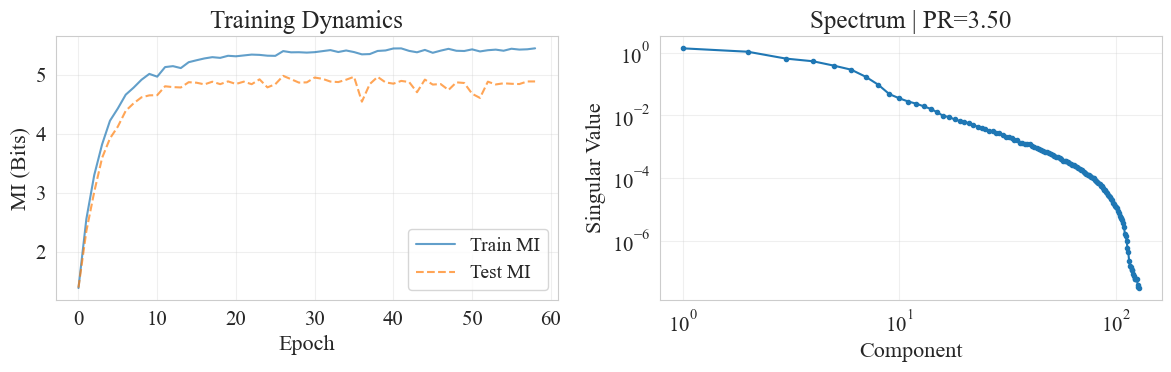

Run completed; saved to temp_finite.h5
✅ Horizontal Completed. D_eff (Train PR): 3.12

>>> Running Strategy: Vertical
Using device: mps
--- DEBUG MODE ON: Using device mps ---


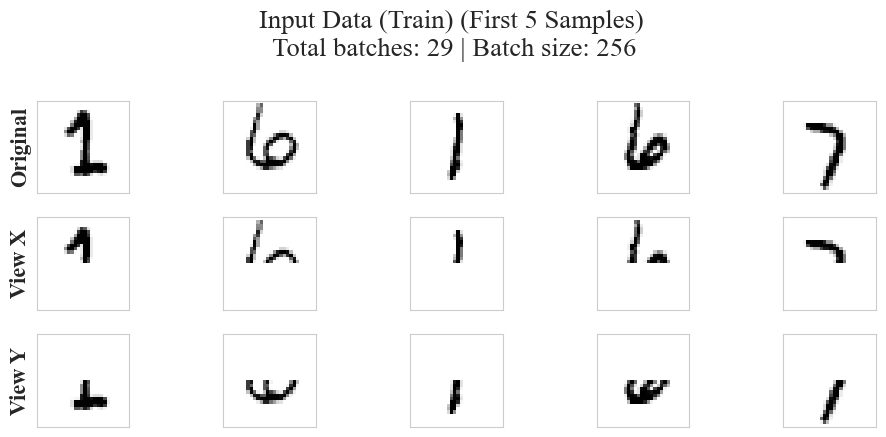

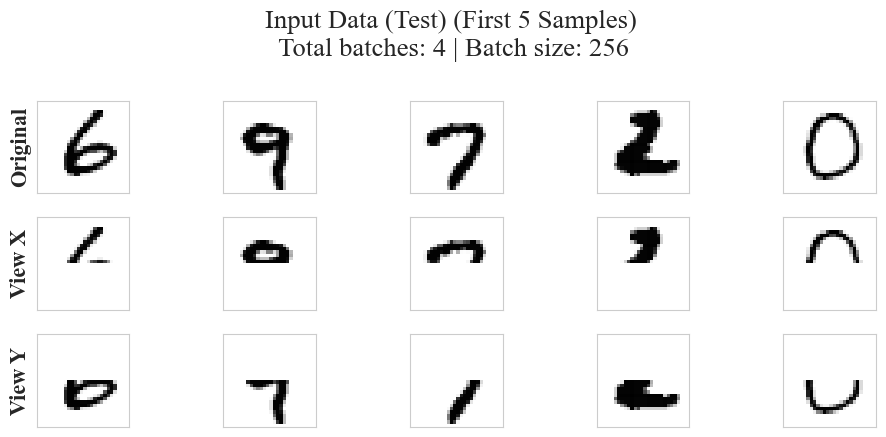

Model is DVSIB: Using variational=True, beta=2048.0


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 36. Best Smoothed Test MI: 4.4747


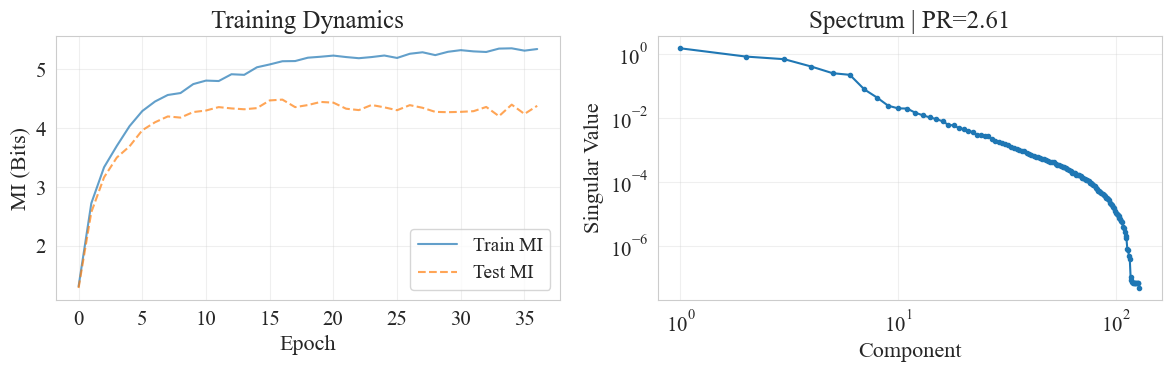

Run completed; saved to temp_finite.h5
✅ Vertical Completed. D_eff (Train PR): 2.36

>>> Running Strategy: Diag_Main
Using device: mps
--- DEBUG MODE ON: Using device mps ---


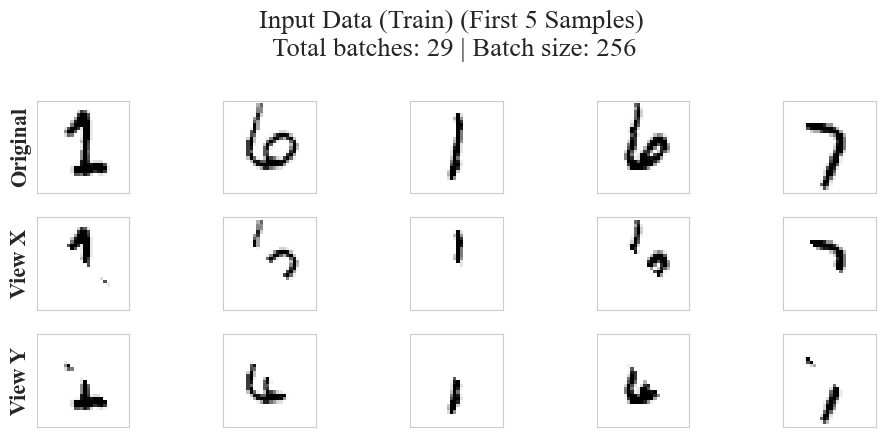

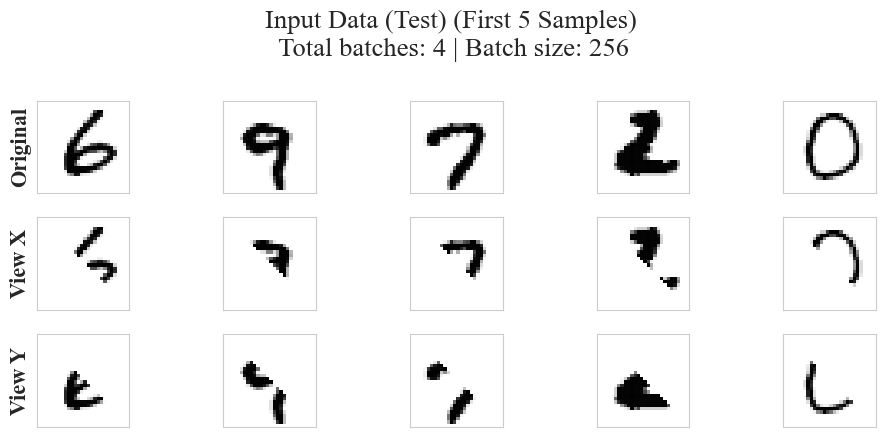

Model is DVSIB: Using variational=True, beta=2048.0


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 83. Best Smoothed Test MI: 5.1036


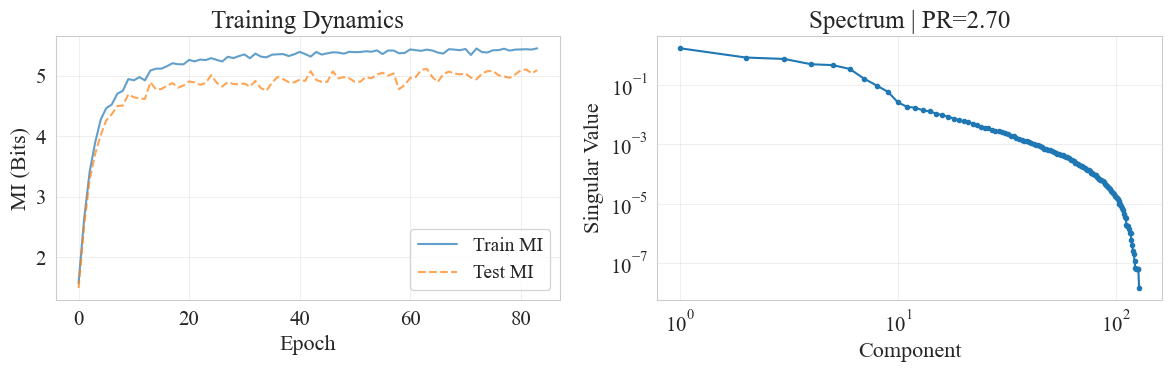

Run completed; saved to temp_finite.h5
✅ Diag_Main Completed. D_eff (Train PR): 2.45

>>> Running Strategy: Diag_Anti
Using device: mps
--- DEBUG MODE ON: Using device mps ---


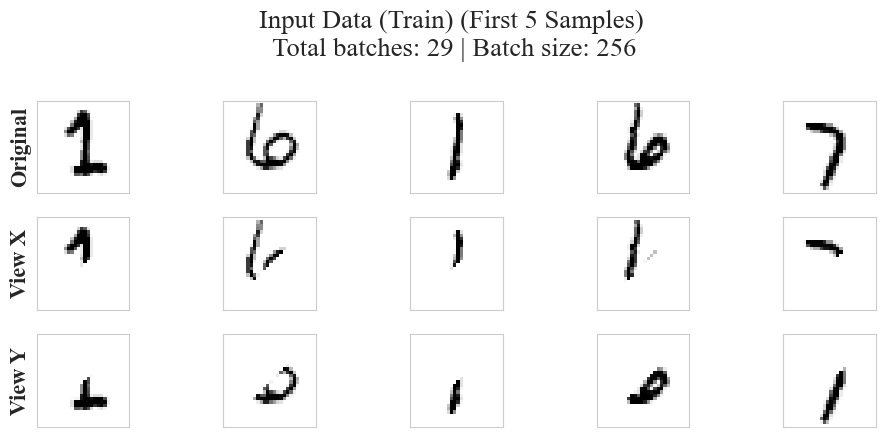

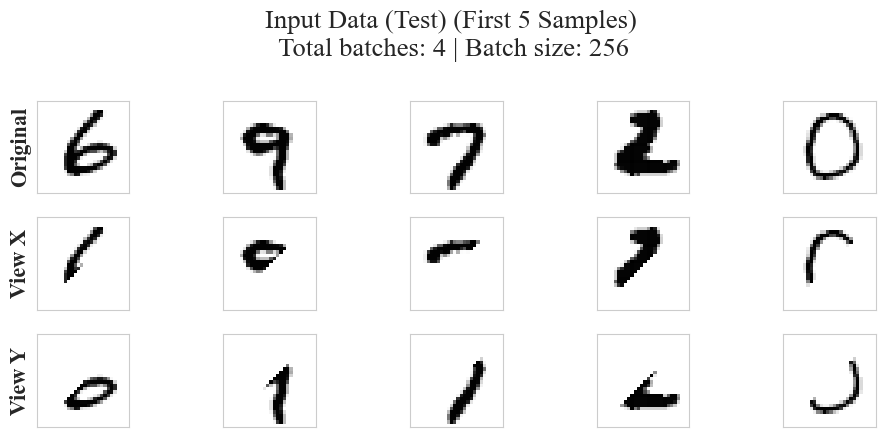

Model is DVSIB: Using variational=True, beta=2048.0


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 43. Best Smoothed Test MI: 4.9064


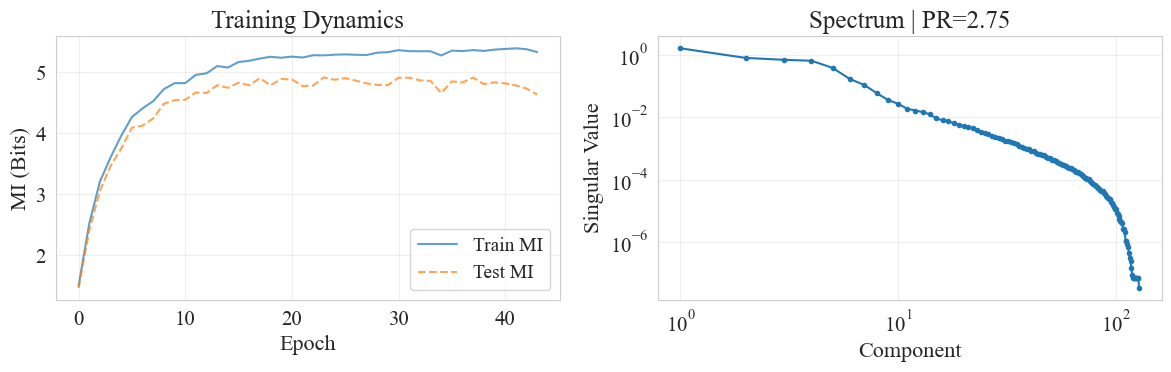

Run completed; saved to temp_finite.h5
✅ Diag_Anti Completed. D_eff (Train PR): 2.45

>>> Running Strategy: Random_50
Using device: mps
--- DEBUG MODE ON: Using device mps ---


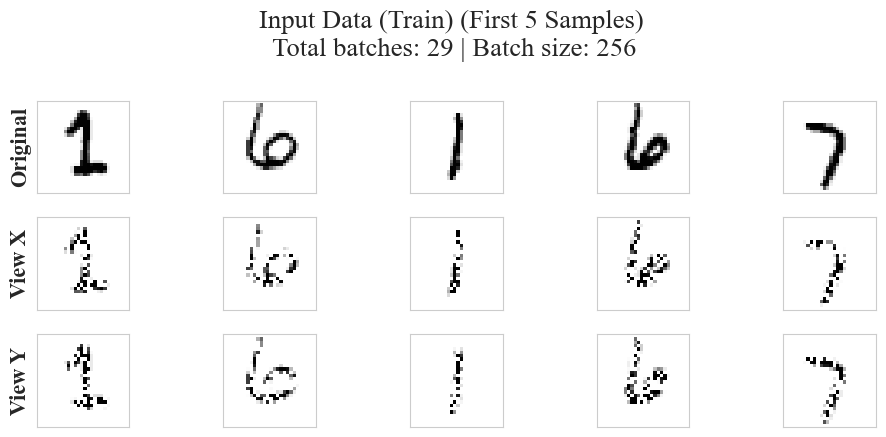

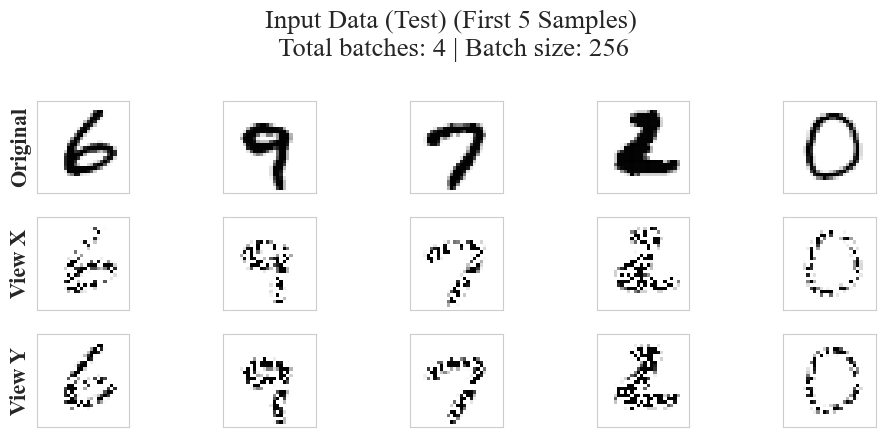

Model is DVSIB: Using variational=True, beta=2048.0


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 78. Best Smoothed Test MI: 6.6195


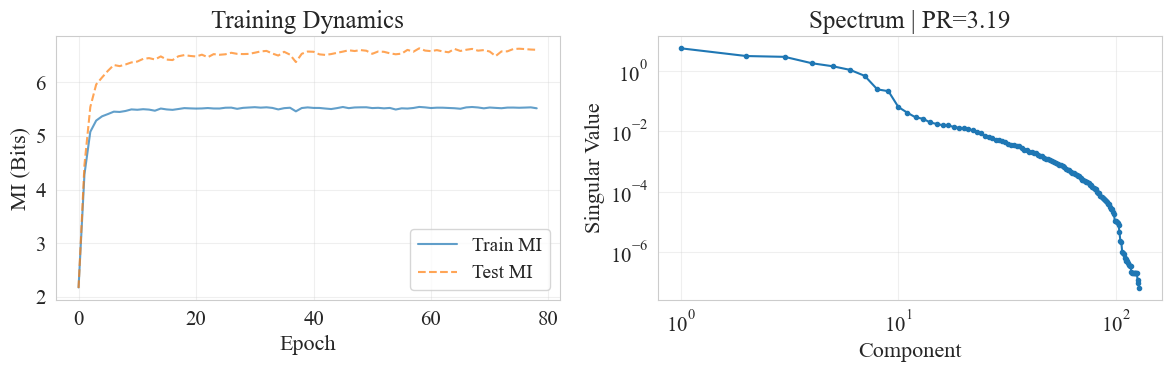

Run completed; saved to temp_finite.h5
✅ Random_50 Completed. D_eff (Train PR): 2.75

--- Final Results ---
     Strategy  Samples     D_eff
0  Horizontal     5000  3.119938
1    Vertical     5000  2.355580
2   Diag_Main     5000  2.446718
3   Diag_Anti     5000  2.449015
4   Random_50     5000  2.750395


In [1]:
import torch
import numpy as np
import pandas as pd
import os
import sys

# Ensure library is in path
sys.path.append(os.getcwd())

from dim_est.run.run_single_experiment import run_finite

# --- Configuration ---
DATA_PATH = "mnist_data.pt"
OUTFILE = "temp_finite.h5"
N_SAMPLES = 5000     
N_EPOCHS = 100       
BATCH_SIZE = 256
EMBED_DIM = 128      

# Define the strategies to sweep
strategies = {
    "Horizontal":  {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 2}},
    "Vertical":    {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 1}},
    "Diag_Main":   {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": 1}},
    "Diag_Anti":   {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": -1}},
    "Random_50":   {"split_strategy": "random_feature", "split_params": {"fraction": 0.5, "seed": 42}},
}

def run_estimation_sweep():
    results = []
    
    print(f"--- Starting MNIST ID Estimation (Samples: {N_SAMPLES}) ---")
    
    for name, split_cfg in strategies.items():
        print(f"\n>>> Running Strategy: {name}")
        
        # 1. Setup Overrides
        dataset_overrides = {
            "source": "external",
            "data_path": DATA_PATH,
            "split_strategy": split_cfg["split_strategy"],
            "split_params": split_cfg["split_params"],
        }
        
        training_overrides = {
            "n_epoch": N_EPOCHS,
            "batch_size": BATCH_SIZE,
            "n_samples": N_SAMPLES,
            "eval_train_mode": False,
            "eval_train_mode_final": False,
            "patience": 20,
        }
        
        critic_overrides = {
            "encoder_type": "mlp",
            "embed_dim": EMBED_DIM,
        }

        model_overrides = {
            "model_type": "dvsib",
            # "params": {"beta": 1024},
        }
        
        # 2. Run Estimation with DEBUG=True
        try:
            _, _, final_pr, _, _ = run_finite(
                dataset_type="joint_gaussian", 
                critic_type="hybrid",          
                setup="finite_data_epoch",
                outfile=OUTFILE,
                dataset_overrides=dataset_overrides,
                training_overrides=training_overrides,
                critic_overrides=critic_overrides,
                model_overrides=model_overrides,
                seed=42,
                debug=True # <--- POP UP VISUALIZATIONS
            )
            
            d_eff = final_pr[0]
            print(f"✅ {name} Completed. D_eff (Train PR): {d_eff:.2f}")
            
            results.append({
                "Strategy": name,
                "Samples": N_SAMPLES,
                "D_eff": d_eff,
            })
            
        except Exception as e:
            print(f"❌ {name} Failed: {e}")
            import traceback
            traceback.print_exc()

    print("\n--- Final Results ---")
    df = pd.DataFrame(results)
    print(df)
    return df

if __name__ == "__main__":
    if not os.path.exists(DATA_PATH):
        print(f"Error: {DATA_PATH} not found.")
    else:
        df_out = run_estimation_sweep()

In [ ]:
import torch
import numpy as np
import pandas as pd
import os
import sys

# Ensure library is in path
sys.path.append(os.getcwd())

from dim_est.run.run_single_experiment import run_finite

# --- Configuration ---
DATA_PATH = "mnist_data.pt"
OUTFILE = "temp_finite.h5"
N_SAMPLES = 5000     
N_EPOCHS = 100       
BATCH_SIZE = 256
EMBED_DIM = 128      

# Define the strategies to sweep
strategies = {
    "Horizontal":  {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 2}},
    # "Vertical":    {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 1}},
    # "Diag_Main":   {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": 1}},
    # "Diag_Anti":   {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": -1}},
    "Random_50":   {"split_strategy": "random_feature", "split_params": {"fraction": 0.5, "seed": 42}},
}
# Beta list, from 1/4 to 2
beta_lst = np.logspace(-2, 4, num=7, dtype=int, base=2)
def run_estimation_sweep():
    results = []
    
    print(f"--- Starting MNIST ID Estimation (Samples: {N_SAMPLES}) ---")

    
    for name, split_cfg in strategies.items():
        print(f"\n>>> Running Strategy: {name}")
        
        # 1. Setup Overrides
        dataset_overrides = {
            "source": "external",
            "data_path": DATA_PATH,
            "split_strategy": split_cfg["split_strategy"],
            "split_params": split_cfg["split_params"],
        }
        
        training_overrides = {
            "n_epoch": N_EPOCHS,
            "batch_size": BATCH_SIZE,
            "n_samples": N_SAMPLES,
            "eval_train_mode": False,
            "eval_train_mode_final": False,
            "patience": 20,
        }
        
        critic_overrides = {
            "encoder_type": "mlp",
            "embed_dim": EMBED_DIM,
        }

        model_overrides = {
            "model_type": "dvsib",
            # "params": {"beta": 1024},
        }
        
        # 2. Run Estimation with DEBUG=True
        try:
            _, _, final_pr, _, _ = run_finite(
                dataset_type="joint_gaussian", 
                critic_type="hybrid",          
                setup="finite_data_epoch",
                outfile=OUTFILE,
                dataset_overrides=dataset_overrides,
                training_overrides=training_overrides,
                critic_overrides=critic_overrides,
                model_overrides=model_overrides,
                seed=42,
                debug=True # <--- POP UP VISUALIZATIONS
            )
            
            d_eff = final_pr[0]
            print(f"✅ {name} Completed. D_eff (Train PR): {d_eff:.2f}")
            
            results.append({
                "Strategy": name,
                "Samples": N_SAMPLES,
                "D_eff": d_eff,
            })
            
        except Exception as e:
            print(f"❌ {name} Failed: {e}")
            import traceback
            traceback.print_exc()

    print("\n--- Final Results ---")
    df = pd.DataFrame(results)
    print(df)
    return df

if __name__ == "__main__":
    if not os.path.exists(DATA_PATH):
        print(f"Error: {DATA_PATH} not found.")
    else:
        df_out = run_estimation_sweep()

In [11]:
import torch
import torchvision
import numpy as np
import pandas as pd
import os
import sys

# Ensure library is in path
sys.path.append(os.getcwd())

from dim_est.run.run_single_experiment import run_finite


DATA_PATH = "mnist_data.pt"

def prepare_mnist(path, max_samples=6000):
    # if os.path.exists(path):
    #     print(f"Data found at {path}")
    #     return
        
    print("Downloading MNIST...")
    ds = torchvision.datasets.MNIST(root="./tmp_data", train=True, download=True, 
                                    transform=torchvision.transforms.ToTensor())
    
    # Select subset for speed
    x = ds.data.float() / 255.0  # (60000, 28, 28)
    x = x.unsqueeze(1)           # (60000, 1, 28, 28)
    
    # Take random subset
    indices = torch.randperm(len(x))[:max_samples]
    x_subset = x[indices]
    
    torch.save(x_subset, path)
    print(f"Saved {len(x_subset)} samples to {path}")

# --- Configuration ---
DATA_PATH = "mnist_data.pt"
OUTFILE = "temp_finite.h5"
N_EPOCHS = 100        
BATCH_SIZE = 256
EMBED_DIM = 128       


# Define the strategies
strategies = {
    "Horizontal":  {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 2}},
    "Vertical":    {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 1}},
    "Diag_Main":   {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": 1}},
    "Diag_Anti":   {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": -1}},
    "Random_50":   {"split_strategy": "random_feature", "split_params": {"fraction": 0.5, "seed": 42}},
}

# Define sample sizes to sweep: 2^10 to 2^13 (1024 to 8192)
sample_sizes = np.logspace(10, 13, num=4, dtype=int, base=2)


def run_estimation_sweep():
    # Ensure Output Directory Exists
    os.makedirs(os.path.dirname(OUTFILE) if os.path.dirname(OUTFILE) else ".", exist_ok=True)
    
    results = []
    
    print(f"--- Starting MNIST ID Estimation Sweep ---")
    print(f"Sample Sizes: {sample_sizes}")
    
    for n_samples in sample_sizes:
        print(f"\n==========================================")
        print(f"   Testing Sample Size: {n_samples}")
        prepare_mnist(DATA_PATH, max_samples=n_samples)
        print(f"==========================================")
        
        for name, split_cfg in strategies.items():
            print(f">>> Running Strategy: {name}")
            
            # 1. Setup Overrides
            dataset_overrides = {
                "source": "external",
                "data_path": DATA_PATH,
                "split_strategy": split_cfg["split_strategy"],
                "split_params": split_cfg["split_params"],
            }
            
            # Training: update n_samples dynamically
            training_overrides = {
                "n_epoch": N_EPOCHS,
                "batch_size": BATCH_SIZE,
                "n_samples": int(n_samples), # Ensure standard Python int
                "eval_train_mode": BATCH_SIZE,
                "eval_train_mode_final": False,
                "patience": 20,
            }
            
            critic_overrides = {
                "encoder_type": "mlp",
                "embed_dim": EMBED_DIM,
            }
            
            # 2. Run Estimation
            try:
                running_mi, _, final_pr, _, _ = run_finite(
                    dataset_type="joint_gaussian", 
                    critic_type="hybrid",          
                    setup="finite_data_epoch",
                    outfile=OUTFILE,
                    # estimator='smile_5',
                    dataset_overrides=dataset_overrides,
                    training_overrides=training_overrides,
                    critic_overrides=critic_overrides,
                    seed=42
                )
                
                # Extract Train PR (D_eff) and MI information
                d_eff = final_pr[0]
                mi = running_mi[0][np.argmax(running_mi[1])]
                
                print(f"✅ {name} (N={n_samples}) -> D_eff: {d_eff:.2f}, MI: {mi:.2f}")
                
                results.append({
                    "Strategy": name,
                    "Samples": n_samples,
                    "D_eff": d_eff,
                    "MI": mi
                })
                
            except Exception as e:
                print(f"❌ {name} (N={n_samples}) Failed: {e}")
                # Optional: print traceback if needed for deep debugging
                # import traceback
                # traceback.print_exc()

    # 3. Summary
    print("\n--- Final Results ---")
    df = pd.DataFrame(results)
    print(df)
    
    # Save results to CSV for easy plotting later
    # df.to_csv("mnist_sample_sweep_results.csv", index=False)
    return df

In [12]:
df_out_lclip = run_estimation_sweep()

--- Starting MNIST ID Estimation Sweep ---
Sample Sizes: [1024 2048 4096 8192]

   Testing Sample Size: 1024
Saved 1024 samples to mnist_data.pt
>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 38. Best Smoothed Test MI: 2.2740
Run completed; saved to temp_finite.h5
✅ Horizontal (N=1024) -> D_eff: 1.92, MI: 6.49
>>> Running Strategy: Vertical
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 37. Best Smoothed Test MI: 2.1613
Run completed; saved to temp_finite.h5
✅ Vertical (N=1024) -> D_eff: 1.39, MI: 6.01
>>> Running Strategy: Diag_Main
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 47. Best Smoothed Test MI: 2.1976
Run completed; saved to temp_finite.h5
✅ Diag_Main (N=1024) -> D_eff: 1.51, MI: 7.45
>>> Running Strategy: Diag_Anti
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 42. Best Smoothed Test MI: 2.1433
Run completed; saved to temp_finite.h5
✅ Diag_Anti (N=1024) -> D_eff: 1.47, MI: 6.56
>>> Running Strategy: Random_50
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 48. Best Smoothed Test MI: 3.9377
Run completed; saved to temp_finite.h5
✅ Random_50 (N=1024) -> D_eff: 1.27, MI: 7.93

   Testing Sample Size: 2048
Saved 2048 samples to mnist_data.pt
>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 40. Best Smoothed Test MI: 3.2113
Run completed; saved to temp_finite.h5
✅ Horizontal (N=2048) -> D_eff: 2.42, MI: 7.31
>>> Running Strategy: Vertical
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 39. Best Smoothed Test MI: 2.9005
Run completed; saved to temp_finite.h5
✅ Vertical (N=2048) -> D_eff: 2.10, MI: 6.71
>>> Running Strategy: Diag_Main
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 40. Best Smoothed Test MI: 2.9480
Run completed; saved to temp_finite.h5
✅ Diag_Main (N=2048) -> D_eff: 1.92, MI: 7.31
>>> Running Strategy: Diag_Anti
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 39. Best Smoothed Test MI: 3.1057
Run completed; saved to temp_finite.h5
✅ Diag_Anti (N=2048) -> D_eff: 2.12, MI: 7.12
>>> Running Strategy: Random_50
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 54. Best Smoothed Test MI: 4.7977
Run completed; saved to temp_finite.h5
✅ Random_50 (N=2048) -> D_eff: 1.82, MI: 7.97

   Testing Sample Size: 4096
Saved 4096 samples to mnist_data.pt
>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 35. Best Smoothed Test MI: 4.0691
Run completed; saved to temp_finite.h5
✅ Horizontal (N=4096) -> D_eff: 2.39, MI: 7.50
>>> Running Strategy: Vertical
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 34. Best Smoothed Test MI: 3.7556
Run completed; saved to temp_finite.h5
✅ Vertical (N=4096) -> D_eff: 1.87, MI: 7.56
>>> Running Strategy: Diag_Main
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 46. Best Smoothed Test MI: 4.0950
Run completed; saved to temp_finite.h5
✅ Diag_Main (N=4096) -> D_eff: 2.04, MI: 7.72
>>> Running Strategy: Diag_Anti
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 48. Best Smoothed Test MI: 4.1263
Run completed; saved to temp_finite.h5
✅ Diag_Anti (N=4096) -> D_eff: 2.45, MI: 7.69
>>> Running Strategy: Random_50
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Run completed; saved to temp_finite.h5
✅ Random_50 (N=4096) -> D_eff: 2.94, MI: 7.98

   Testing Sample Size: 8192
Saved 8192 samples to mnist_data.pt
>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 57. Best Smoothed Test MI: 5.1021
Run completed; saved to temp_finite.h5
✅ Horizontal (N=8192) -> D_eff: 3.17, MI: 7.85
>>> Running Strategy: Vertical
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 42. Best Smoothed Test MI: 4.4836
Run completed; saved to temp_finite.h5
✅ Vertical (N=8192) -> D_eff: 2.09, MI: 7.47
>>> Running Strategy: Diag_Main
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 60. Best Smoothed Test MI: 5.1723
Run completed; saved to temp_finite.h5
✅ Diag_Main (N=8192) -> D_eff: 2.60, MI: 7.85
>>> Running Strategy: Diag_Anti
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 48. Best Smoothed Test MI: 4.9270
Run completed; saved to temp_finite.h5
✅ Diag_Anti (N=8192) -> D_eff: 3.29, MI: 7.69
>>> Running Strategy: Random_50
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Run completed; saved to temp_finite.h5
✅ Random_50 (N=8192) -> D_eff: 3.47, MI: 7.98

--- Final Results ---
      Strategy  Samples     D_eff        MI
0   Horizontal     1024  1.918020  6.490887
1     Vertical     1024  1.390926  6.012939
2    Diag_Main     1024  1.511785  7.452714
3    Diag_Anti     1024  1.469632  6.556844
4    Random_50     1024  1.273305  7.932017
5   Horizontal     2048  2.419277  7.311885
6     Vertical     2048  2.103426  6.707827
7    Diag_Main     2048  1.921553  7.309574
8    Diag_Anti     2048  2.119342  7.122551
9    Random_50     2048  1.818683  7.970578
10  Horizontal     4096  2.391624  7.499817
11    Vertical     4096  1.867217  7.560738
12   Diag_Main     4096  2.040747  7.724007
13   Diag_Anti     4096  2.451574  7.685415
14   Random_50     4096  2.941954  7.977254
15  Horizontal     8192  3.168386  7.847180
16    Vertical     8192  2.094982  7.466844
17   Diag_Main     8192  2.598473  7.850573
18   Diag_Anti     8192  3.287083  7.686352
19   Random_

In [14]:
import torch
import torchvision
import numpy as np
import pandas as pd
import os
import sys

# Ensure library is in path
sys.path.append(os.getcwd())

from dim_est.run.run_single_experiment import run_finite


DATA_PATH = "mnist_data.pt"

def prepare_mnist(path, max_samples=6000):
    # if os.path.exists(path):
    #     print(f"Data found at {path}")
    #     return
        
    print("Downloading MNIST...")
    ds = torchvision.datasets.MNIST(root="./tmp_data", train=True, download=True, 
                                    transform=torchvision.transforms.ToTensor())
    
    # Select subset for speed
    x = ds.data.float() / 255.0  # (60000, 28, 28)
    x = x.unsqueeze(1)           # (60000, 1, 28, 28)
    
    # Take random subset
    indices = torch.randperm(len(x))[:max_samples]
    x_subset = x[indices]
    
    torch.save(x_subset, path)
    print(f"Saved {len(x_subset)} samples to {path}")

# --- Configuration ---
DATA_PATH = "mnist_data.pt"
OUTFILE = "temp_finite.h5"
N_EPOCHS = 100        
BATCH_SIZE = 256
EMBED_DIM = 128       


# Define the strategies
strategies = {
    "Horizontal":  {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 2}},
    "Vertical":    {"split_strategy": "spatial", "split_params": {"mode": "axis", "axis": 1}},
    "Diag_Main":   {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": 1}},
    "Diag_Anti":   {"split_strategy": "spatial", "split_params": {"mode": "diagonal", "diagonal_dir": -1}},
    "Random_50":   {"split_strategy": "random_feature", "split_params": {"fraction": 0.5, "seed": 42}},
}

# Define sample sizes to sweep: 2^10 to 2^13 (1024 to 8192)
sample_sizes = np.logspace(10, 13, num=4, dtype=int, base=2)


def run_estimation_sweep():
    # Ensure Output Directory Exists
    os.makedirs(os.path.dirname(OUTFILE) if os.path.dirname(OUTFILE) else ".", exist_ok=True)
    
    results = []
    
    print(f"--- Starting MNIST ID Estimation Sweep ---")
    print(f"Sample Sizes: {sample_sizes}")
    
    for n_samples in sample_sizes:
        print(f"\n==========================================")
        print(f"   Testing Sample Size: {n_samples}")
        prepare_mnist(DATA_PATH, max_samples=n_samples)
        print(f"==========================================")
        
        for name, split_cfg in strategies.items():
            print(f">>> Running Strategy: {name}")
            
            # 1. Setup Overrides
            dataset_overrides = {
                "source": "external",
                "data_path": DATA_PATH,
                "split_strategy": split_cfg["split_strategy"],
                "split_params": split_cfg["split_params"],
            }
            
            # Training: update n_samples dynamically
            training_overrides = {
                "n_epoch": N_EPOCHS,
                "batch_size": BATCH_SIZE,
                "n_samples": int(n_samples), # Ensure standard Python int
                "eval_train_mode": BATCH_SIZE,
                "eval_train_mode_final": False,
                "patience": 20,
            }
            
            critic_overrides = {
                "encoder_type": "mlp",
                "embed_dim": EMBED_DIM,
                "variational": True,  # <--- Enable Variational Critic
            }

            model_overrides = {
                "model_type": "dvsib",
                "params": {"beta": 256},
            }
            
            # 2. Run Estimation
            try:
                running_mi, _, final_pr, _, _ = run_finite(
                    dataset_type="joint_gaussian", 
                    critic_type="hybrid",          
                    setup="finite_data_epoch",
                    outfile=OUTFILE,
                    dataset_overrides=dataset_overrides,
                    training_overrides=training_overrides,
                    critic_overrides=critic_overrides,
                    seed=42
                )
                
                # Extract Train PR (D_eff) and MI information
                d_eff = final_pr[0]
                mi = running_mi[0][np.argmax(running_mi[1])]
                
                print(f"✅ {name} (N={n_samples}) -> D_eff: {d_eff:.2f}, MI: {mi:.2f}")
                
                results.append({
                    "Strategy": name,
                    "Samples": n_samples,
                    "D_eff": d_eff,
                    "MI": mi
                })
                
            except Exception as e:
                print(f"❌ {name} (N={n_samples}) Failed: {e}")
                # Optional: print traceback if needed for deep debugging
                # import traceback
                # traceback.print_exc()

    # 3. Summary
    print("\n--- Final Results ---")
    df = pd.DataFrame(results)
    print(df)
    
    # Save results to CSV for easy plotting later
    # df.to_csv("mnist_sample_sweep_results.csv", index=False)
    return df

In [15]:
df_out_lclip_dvsib = run_estimation_sweep()

--- Starting MNIST ID Estimation Sweep ---
Sample Sizes: [1024 2048 4096 8192]

   Testing Sample Size: 1024
Saved 1024 samples to mnist_data.pt
>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 47. Best Smoothed Test MI: 1.1049
Run completed; saved to temp_finite.h5
✅ Horizontal (N=1024) -> D_eff: 1.00, MI: 2.16
>>> Running Strategy: Vertical
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 49. Best Smoothed Test MI: 1.1584
Run completed; saved to temp_finite.h5
✅ Vertical (N=1024) -> D_eff: 1.00, MI: 2.44
>>> Running Strategy: Diag_Main
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 46. Best Smoothed Test MI: 1.2123
Run completed; saved to temp_finite.h5
✅ Diag_Main (N=1024) -> D_eff: 1.00, MI: 2.24
>>> Running Strategy: Diag_Anti
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 46. Best Smoothed Test MI: 0.9912
Run completed; saved to temp_finite.h5
✅ Diag_Anti (N=1024) -> D_eff: 1.00, MI: 2.09
>>> Running Strategy: Random_50
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 70. Best Smoothed Test MI: 1.6842
Run completed; saved to temp_finite.h5
✅ Random_50 (N=1024) -> D_eff: 1.00, MI: 3.63

   Testing Sample Size: 2048
Saved 2048 samples to mnist_data.pt
>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 44. Best Smoothed Test MI: 1.2551
Run completed; saved to temp_finite.h5
✅ Horizontal (N=2048) -> D_eff: 1.00, MI: 2.22
>>> Running Strategy: Vertical
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 46. Best Smoothed Test MI: 1.3392
Run completed; saved to temp_finite.h5
✅ Vertical (N=2048) -> D_eff: 1.00, MI: 2.43
>>> Running Strategy: Diag_Main
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 58. Best Smoothed Test MI: 1.2780
Run completed; saved to temp_finite.h5
✅ Diag_Main (N=2048) -> D_eff: 1.00, MI: 3.67
>>> Running Strategy: Diag_Anti
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 36. Best Smoothed Test MI: 1.2141
Run completed; saved to temp_finite.h5
✅ Diag_Anti (N=2048) -> D_eff: 1.00, MI: 2.02
>>> Running Strategy: Random_50
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 39. Best Smoothed Test MI: 1.9687
Run completed; saved to temp_finite.h5
✅ Random_50 (N=2048) -> D_eff: 1.00, MI: 3.50

   Testing Sample Size: 4096
Saved 4096 samples to mnist_data.pt
>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 38. Best Smoothed Test MI: 1.9673
Run completed; saved to temp_finite.h5
✅ Horizontal (N=4096) -> D_eff: 1.16, MI: 3.90
>>> Running Strategy: Vertical
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 61. Best Smoothed Test MI: 2.5822
Run completed; saved to temp_finite.h5
✅ Vertical (N=4096) -> D_eff: 1.07, MI: 5.73
>>> Running Strategy: Diag_Main
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 63. Best Smoothed Test MI: 2.2327
Run completed; saved to temp_finite.h5
✅ Diag_Main (N=4096) -> D_eff: 1.03, MI: 5.60
>>> Running Strategy: Diag_Anti
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 42. Best Smoothed Test MI: 1.9489
Run completed; saved to temp_finite.h5
✅ Diag_Anti (N=4096) -> D_eff: 1.04, MI: 3.77
>>> Running Strategy: Random_50
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Run completed; saved to temp_finite.h5
✅ Random_50 (N=4096) -> D_eff: 1.14, MI: 7.95

   Testing Sample Size: 8192
Saved 8192 samples to mnist_data.pt
>>> Running Strategy: Horizontal
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 71. Best Smoothed Test MI: 4.1424
Run completed; saved to temp_finite.h5
✅ Horizontal (N=8192) -> D_eff: 1.37, MI: 7.43
>>> Running Strategy: Vertical
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 53. Best Smoothed Test MI: 3.7249
Run completed; saved to temp_finite.h5
✅ Vertical (N=8192) -> D_eff: 1.22, MI: 6.49
>>> Running Strategy: Diag_Main
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 84. Best Smoothed Test MI: 3.8423
Run completed; saved to temp_finite.h5
✅ Diag_Main (N=8192) -> D_eff: 1.14, MI: 7.75
>>> Running Strategy: Diag_Anti
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 54. Best Smoothed Test MI: 3.5775
Run completed; saved to temp_finite.h5
✅ Diag_Anti (N=8192) -> D_eff: 1.19, MI: 6.67
>>> Running Strategy: Random_50
Using device: mps


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Run completed; saved to temp_finite.h5
✅ Random_50 (N=8192) -> D_eff: 1.24, MI: 7.99

--- Final Results ---
      Strategy  Samples     D_eff        MI
0   Horizontal     1024  1.000000  2.162685
1     Vertical     1024  1.000000  2.443135
2    Diag_Main     1024  1.000000  2.239471
3    Diag_Anti     1024  1.000001  2.092571
4    Random_50     1024  1.000000  3.632043
5   Horizontal     2048  1.000002  2.215105
6     Vertical     2048  1.000001  2.428397
7    Diag_Main     2048  1.002807  3.667236
8    Diag_Anti     2048  1.000000  2.018977
9    Random_50     2048  1.000001  3.499409
10  Horizontal     4096  1.155649  3.902857
11    Vertical     4096  1.066981  5.728924
12   Diag_Main     4096  1.029513  5.601799
13   Diag_Anti     4096  1.042186  3.768701
14   Random_50     4096  1.143482  7.950316
15  Horizontal     8192  1.372199  7.432355
16    Vertical     8192  1.223932  6.486323
17   Diag_Main     8192  1.139634  7.748189
18   Diag_Anti     8192  1.186131  6.672425
19   Random_

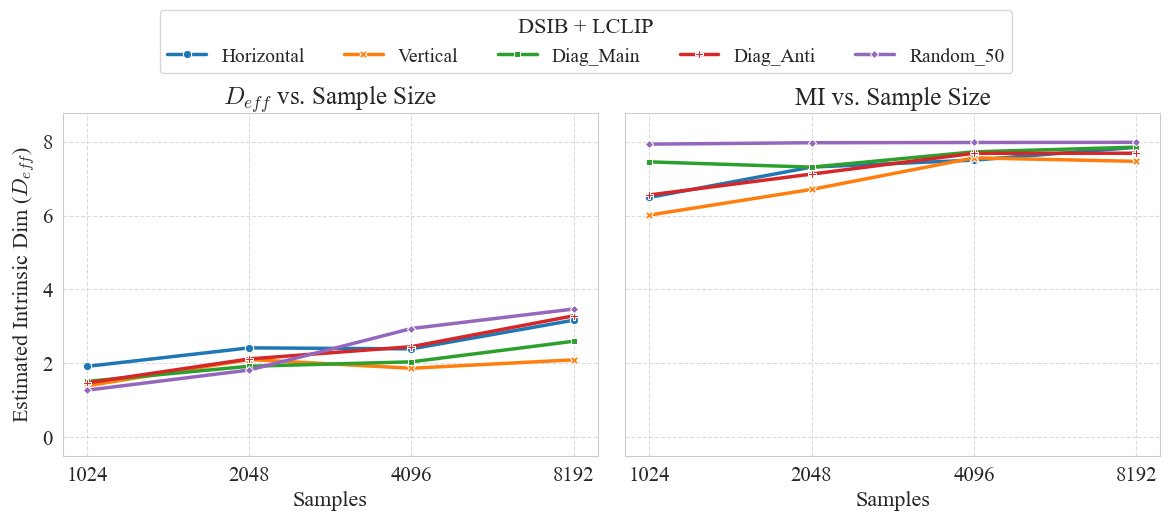

In [13]:
plot_results(df_out_lclip, title="DSIB + LCLIP")

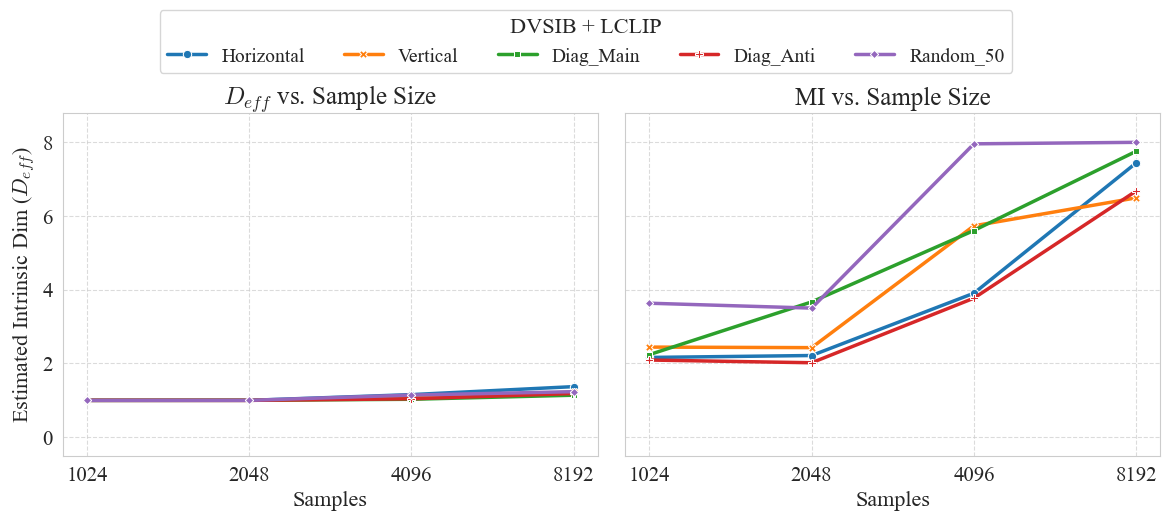

In [16]:
plot_results(df_out_lclip_dvsib, title="DVSIB + LCLIP")